In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
from matplotlib.backends.backend_pdf import PdfPages
from itertools import permutations
from scipy.interpolate import BSpline
sns.set()


In [2]:
# Function to imort file or files from a local folder
def import_file(folder_path = "folder_name"):
    
    """
    This function will import the CSV file from the HDExaminer into the environment from a local folder.
    
    Parameter:
    ----------
    folder_path: str, name of the folder containing the CSV file. 
    
    output:
    -------
    a dataframe
    
    """
    for file in os.listdir(folder_path):    
        if file.endswith(".csv"):    
            filepath = os.path.join(folder_path, file)   
    df = pd.read_csv(filepath)
    return df

In [3]:
class HDX(object):
    
    def __init__(self, df, states_list, pep_map = None):
        
        """
        The function of this class is to preproces the CSV file extracted from HDExaminer so
        the processed dataframe can be used to create various kind of plots including scatter,
        line, bar, bubble, heatmap and others. The states_list is a list of protein states in 
        the CSV file. These states could be WT and its mutants or a protein with different substrate
        complexes such apo, binary, ternary and so on. 
        This class will preprocess all the states found in the "Protein State" column in the csv file.
        
        parameters:
        ----------
        df: a dataframe of the CSV file which ws generated using the above "import_file" function. 
        states_list: list, a list of of the state names. The total number of states in the state_list
                    has to match with that in the CSV file.
        pep_map: dictinary, a dictionary of domain names and the corresponding region in the protein.
        
        
        output:
        -------
        a dataframe. 
        
        """
            
        self.pep_map = {"WED I": range(1, 1+24), 
               "REC 1": range(25, 1+339),
               "REC 2": range(340, 1+591),
               "WED II": range(592, 1+662),
               "PI": range(663, 1+762),
               "WED III": range(763, 1+892),
               "RuvC I": range(893, 1+953),
               "BH": range(954, 1+971),
               "RuvC II": range(972, 1+1078),
               "Nuc": range(1079, 1+1254),
               "RuvC III": range(1255, 1+1300)}

        
        self.states_list = states_list
        self.df = df

    def rename_states(self):
        
        """
        It returns the dataframe with the name of states provided. 

        """
        
        states = self.df['Protein State'].unique()
        state_renames ={}

        for st, stls in zip(states, self.states_list):
            state_renames[st] =stls
        self.df['Protein State'].replace(state_renames, inplace=True)

        return df


    def organize(self):

        """
        This functin will organize all the states in the data frame
        so that individual states can be plotted efficiently. It returns a dataframe.

        """
        # Updating the df using rename_states function with the default parameters
        #so that the current function can be used independently.
        df = self.rename_states()
        
        # List of states in the csv file.
        states = list(df['Protein State'].unique())
        
        # Now separating states as an individulat dataframe and collecting it as list under frames.
        frames =[]

        for state in states:
            state = df[df['Protein State']==state]
            frames.append(state)

        # Renaming states needed to join the abovedata frames horizontally.
        renamed_states =[]
        for state in states:
            state = "_"+ state
            renamed_states.append(state)

        # Combining all dataframes(each individual states) in the frames.
        df = reduce(lambda left,right: pd.merge(left,right,
                                                 on=['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD'],
                                              how='outer', suffixes= tuple(renamed_states[:-1])), frames)

        colnames = list(df.columns)

        # Renaming the columns of the state so that it matches with the other states
        new_names = [i + "_" + self.states_list[-1] for i in colnames[-8:]]

        maps={}
        for i, j in zip(colnames[-8:], new_names):
            maps[i] =j

        df= df.rename(columns= maps)

        return df

    def pre_process(self):
        
        """
        This function will generate multiple columns. Each column will have 
        different type of naming for each peptides. For example, the peps column
        will contain the peptide number,its unique index number, the start and end of the sequence.
        This will be highly benificial to indentify peptides in a plot. It also
        reindexes the dataframe by the unique peptide numbers. 
        It returns a dataframe.
        """
        
        df = self.organize()

        # indexing unique peptides from 1.
        idx = range(1,1+len([i for i in df['Sequence'].unique()]))

        idx_dict = {idx: i for (idx, i) in zip(idx, df['Sequence'].unique())}

        df['idx_pep'] = [idx for idx, pep in idx_dict.items() for p in df['Sequence'] if p == pep]

        # New Column containg the unique index number and the start and end of the sequence

        df['idx']= df['idx_pep'].astype("str") + df.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df.End.astype("str").apply(
            lambda x: x + ")"
        )

        # New Column containg the peptides, its unique index number and the start and end of the sequence

        df['peps'] = df['idx_pep'].astype("str").apply(
            lambda x: x + ". "
        ) + df['Sequence'] + df.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df.End.astype("str").apply(
            lambda x: x + ")"
        )

        # setting the idx_pep column as the index of the dataframe
        df.index = df['idx_pep']

        df = df.rename({"idx":"idx1"}, axis = 1)
        df.index.names = ["idx"]
        # Adding column whoso values correspond to timepoints as t1, t2, t3....
        
        timepoints = df['Deut Time (sec)'].unique()
        
        timepoint_names=[]
        for timepoint in range(1, len(timepoints) +1):
            timepoint_names.append("t" + str(timepoint))
            
        timepoint_map={}    
        for timpoint, timepoint_name in zip(timepoints, timepoint_names):
            timepoint_map[timpoint]=timepoint_name

        df['timepoint_map'] = df['Deut Time (sec)']
        df['timepoint_map'] = df["timepoint_map"].map(timepoint_map)
        
        return df
    
    def state_diff(self):
        """ 
        This function names the column that 
        will be generated from the vectorized operations.
        
        """
        
        stls = list(permutations(self.states_list, 2))
        
        st_li =[]
        
        for i in range(len(stls)):
            
            a = stls[i]
            
            new = a[0]+"_"+a[1]
            
            st_li.append(new)
        
        return st_li
    
    def state_diff_error(self):
        
        """
        This function names the column that 
        will be generated from the vectorized operations,
        
        """
        
        stls = list(permutations(self. states_list, 2))
        
        stls_error = [(i,'std' ) for i in stls]
        
        st_li_er =[]
        
        for i in range(len(stls_error)):
            
            a,b = stls_error[i]
            
            new = a[0]+"_"+a[1]+ "_" + b
            
            st_li_er.append(new)
            
        return st_li_er

    def domains_mapping(self):
        
        """
        The pep_map is a dictionary mapping peptides sequence 
        number to the respective domains name.
        It returns the data frmae with a column, named "domain",
        whose values are the mapped domain names of the protein.
        
        """
        df = self.pre_process()
        
        # Creating list of Start numbers from the "Start" Column
        start = list(df.Start)

        # Creating list of End numbers from the "End" Column
        end = list(df.End)

        # Creating a list mapping the start and end numbers to its domain names of the protein using the pep_map Dictionary
        sts = []
        ens = []
        for keys, values in self.pep_map.items():
            for d in values:

                for st in start:
                    if st == d:
                        sts.append(keys)

                for en in end:
                    if en == d:
                        ens.append(keys)


        # Finding the peptides and its indexes that shares multiple domains.
        ov =[]
        ov_idx= []
        for (idx, i), (dx,j) in zip(enumerate(sts),enumerate(ens)):
            if i!=j:
                ov.append((sts[idx],ens[dx]))
                ov_idx.append(idx)

        # now renaming those peptides interms of what overlapping domains they belong to 
        ovl =[]            
        for a, b in ov:
            i = a+" - "+b
            ovl.append(i)

        cts = sts.copy()
        #Finally replacing those overlapping peps names in "sts" list with the new names
        for (dx,j), (x,k )in zip(enumerate(ov_idx), enumerate(ovl)):
            cts[j] = k

        # Creating a new column in the data frame with domain name
        df["domains"] = cts
        df["domains_start"] = sts
        
        # A column with a concatenated peptides' names and their domains'names.
        df["pepsdmn"] = df.peps.apply(lambda x: x + " (") + df.domains.apply(lambda x: x + ")")
        df["idxdmn"] = df.idx1.apply(lambda x: x + " (") + df.domains.apply(lambda x: x + ")")
                
        return df
    
    def cal_diff(self):
        
        """ This function calculates the difference in uptakes of D between states"""
        
        sts_comb = list(permutations(self.states_list, 2))
        
        # Making new columns named i showing the differences among multiple states 
        
        df = self.domains_mapping()
        
        for i, j in zip(self.state_diff(), sts_comb):
            
            df[i] = df["#D_" + j[0]] - df["#D_" + j[1]]
            
        # Making new columns named i for the respective errors using standard error propagation rules    
        
        for i, j in zip(self.state_diff_error(), sts_comb):
                
            df[i] = (df["Stddev_" + j[0]]**2 + df["Stddev_" + j[1]]**2).apply(np.sqrt)
        
        df.to_csv("Processed_HDX_file.csv")
            
        return df

### First, import the CSV file and porvide a list of states.

In [4]:
df = import_file(folder_path = "Data")
states_list = ["Apo", "Binary", "Ternary"]

df.head()

,Protein State,Start,End,Sequence,Deut Time (sec),maxD,#D,%D,Conf Interval (#D),#Pts,Confidence,Stddev,p
0,FnCas12a,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,Medium,0.026,NaN
1,FnCas12a,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,Medium,0.012,NaN
2,FnCas12a,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,Medium,0.353,NaN
3,FnCas12a,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,Medium,0.000,NaN
4,FnCas12a,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,Medium,0.406,NaN


In [5]:
df.columns

Index(['Protein State', 'Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD',
       '#D', '%D', 'Conf Interval (#D)', '#Pts', 'Confidence', 'Stddev', 'p'],
      dtype='object')

This is just a unprocessed dataframe imported from the CSV file. Next, I am going to test if all function under the HDX class works fine!

In [6]:
# Instantiate the class
hdx = HDX(df , states_list)

In [7]:
hdx.rename_states().head()

,Protein State,Start,End,Sequence,Deut Time (sec),maxD,#D,%D,Conf Interval (#D),#Pts,Confidence,Stddev,p
0,Apo,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,Medium,0.026,NaN
1,Apo,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,Medium,0.012,NaN
2,Apo,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,Medium,0.353,NaN
3,Apo,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,Medium,0.000,NaN
4,Apo,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,Medium,0.406,NaN


### Note, the "Protein State" column contains the states as was given in the state_list.

In [8]:
hdx.pre_process().head()

,Protein State_Apo,Start,End,Sequence,Deut Time (sec),maxD,#D_Apo,%D_Apo,Conf Interval (#D)_Apo,#Pts_Apo,...,%D_Ternary,Conf Interval (#D)_Ternary,#Pts_Ternary,Confidence_Ternary,Stddev_Ternary,p_Ternary,idx_pep,idx1,peps,timepoint_map
idx,,,,,,,,,,,,,,,,,,,,,
1,Apo,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,...,3.410,0.387,2.0,Medium,0.043,0.011209,1,1 (7-13),1. FVNKYSL (7-13),t1
1,Apo,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,...,15.878,0.441,2.0,Medium,0.049,0.026255,1,1 (7-13),1. FVNKYSL (7-13),t2
1,Apo,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,...,16.491,0.104,2.0,Medium,0.012,0.098001,1,1 (7-13),1. FVNKYSL (7-13),t3
1,Apo,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,...,20.038,0.805,2.0,Medium,0.090,1.000000,1,1 (7-13),1. FVNKYSL (7-13),t4
1,Apo,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,...,20.344,0.599,2.0,Medium,0.067,0.080870,1,1 (7-13),1. FVNKYSL (7-13),t5


In [9]:
hdx.domains_mapping().head()

,Protein State_Apo,Start,End,Sequence,Deut Time (sec),maxD,#D_Apo,%D_Apo,Conf Interval (#D)_Apo,#Pts_Apo,...,Stddev_Ternary,p_Ternary,idx_pep,idx1,peps,timepoint_map,domains,domains_start,pepsdmn,idxdmn
idx,,,,,,,,,,,,,,,,,,,,,
1,Apo,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,...,0.043,0.011209,1,1 (7-13),1. FVNKYSL (7-13),t1,WED I,WED I,1. FVNKYSL (7-13) (WED I),1 (7-13) (WED I)
1,Apo,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,...,0.049,0.026255,1,1 (7-13),1. FVNKYSL (7-13),t2,WED I,WED I,1. FVNKYSL (7-13) (WED I),1 (7-13) (WED I)
1,Apo,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,...,0.012,0.098001,1,1 (7-13),1. FVNKYSL (7-13),t3,WED I,WED I,1. FVNKYSL (7-13) (WED I),1 (7-13) (WED I)
1,Apo,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,...,0.090,1.000000,1,1 (7-13),1. FVNKYSL (7-13),t4,WED I,WED I,1. FVNKYSL (7-13) (WED I),1 (7-13) (WED I)
1,Apo,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,...,0.067,0.080870,1,1 (7-13),1. FVNKYSL (7-13),t5,WED I,WED I,1. FVNKYSL (7-13) (WED I),1 (7-13) (WED I)


In [10]:
hdx.cal_diff().columns

Index(['Protein State_Apo', 'Start', 'End', 'Sequence', 'Deut Time (sec)',
       'maxD', '#D_Apo', '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo',
       'Confidence_Apo', 'Stddev_Apo', 'p_Apo', 'Protein State_Binary',
       '#D_Binary', '%D_Binary', 'Conf Interval (#D)_Binary', '#Pts_Binary',
       'Confidence_Binary', 'Stddev_Binary', 'p_Binary',
       'Protein State_Ternary', '#D_Ternary', '%D_Ternary',
       'Conf Interval (#D)_Ternary', '#Pts_Ternary', 'Confidence_Ternary',
       'Stddev_Ternary', 'p_Ternary', 'idx_pep', 'idx1', 'peps',
       'timepoint_map', 'domains', 'domains_start', 'pepsdmn', 'idxdmn',
       'Apo_Binary', 'Apo_Ternary', 'Binary_Apo', 'Binary_Ternary',
       'Ternary_Apo', 'Ternary_Binary', 'Apo_Binary_std', 'Apo_Ternary_std',
       'Binary_Apo_std', 'Binary_Ternary_std', 'Ternary_Apo_std',
       'Ternary_Binary_std'],
      dtype='object')

### Note, this function generted many columns including pepsdmn, timepoint_maps and others, which will be used to create plots.

In [11]:
class pep_analyzer(HDX):
    
    """
    A derived class from HDX class. This class has multiple functions,
    which will classify the peptides by the uptake differences between two states.
    
    """
    def __init__(self):
        """
         Here I am exploiting the inheritance properties of OOP. 
         So I don't need to instatiate the HDX class when using this class.
         All the function of HDX will be available in this class.
         
        """

        HDX.__init__(self, df = df, states_list = states_list)
    

    
            
    def pep_diff_uptake_class(self, dstate= ('Apo', 'Binary'), st1_st2 = True):
        
        df = self.cal_diff()
        
        a= "#D_" + dstate[0]
        b= "#D_" + dstate[1]
        
        a1 = df.groupby("idx")[a, b].mean()[a]
        b1 =df.groupby("idx")[a, b].mean()[b]
        
        if st1_st2:
            
            # List of peptides for the complex that has more D than the following complex
            pep = df.pepsdmn.unique()[a1>b1] 
            
            pep_idx = df.index.unique()[a1>b1]
            

        else:
            # List of peptides for the complex that has more D than the following complex
            pep = df.pepsdmn.unique()[a1<b1]
            pep_idx = df.index.unique()[a1<b1]

        return pep, list(pep_idx)
    
    def pep_diff_sig_class(self, dstate= ("Apo","Binary"), st1_st2 = True, er_da=1):
        
        df = self.cal_diff()
        
        pep, pep_idx = self.pep_diff_uptake_class(dstate= dstate, st1_st2 = True)

        col = dstate[0] + "_" + dstate[1]
        
        col_error = dstate[0] + "_" + dstate[1] +"_std"
        
        if st1_st2:
            
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].pepsdmn.unique()
            
        else:
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].pepsdmn.unique()
        
        return pep_sig, list(idx_pep_sig)

In [56]:
class plots(pep_analyzer, HDX):
    def __init__(self):
        
        HDX.__init__(self, df = df, states_list = states_list)
        
        pep_analyzer.__init__(self)
        
    
    def name(self, plot_states = ["Apo", 'Binary']):
   
        na = ""
        for st in plot_states:
            na = na + st + "-" 
            name = [i for i in na.split("-")]    
            name = name[:-1]
            name = "-".join(name)
        return name
          
    
    def uptake_plots(self, plot_states = ["Apo", 'Binary'], 
                    domains = None, pep_no = None,  pep_class = None,
                     pdf = False, tiff = False):
        """
        This function will create uptake plots of peptides against log of time.
        
        parameters:
        ----------
        df: dataframe.
        plot_states: list, the name of the plot_states (as many state as you want) to be plotted as a list.
        pep_class: list of peptides, it takes the second output from the function pep_dif_class
                    or pep_diff_sig_class.
        domains: list,  the list of domains you want to plot.
        pep_no: list, it takes individual pep umbers as a list.
        pdf: boolean, if True, it will save a pdf file of all plots.
        tiff: boolean, if True, it will save a tiff image for each peptide
        ----------
        output: it returns plots. 
        """
        
        df = self.cal_diff()
        plt.style.use("ggplot")

        number =[]
        percent =[]
        std = []
        conf = []

        for st in plot_states:
            n = "#D" + "_" + st
            number.append(n)

            p = "%D" + "_" + st
            percent.append(p)

            s = 'Stddev'+ "_" + st
            std.append(s)

            c = 'Conf Interval (#D)'+ "_" + st
            conf.append(c)
            
        if pep_class == None:
            
            if domains == None:
                
                if pep_no == None:
                    
                    unique_indxs = df.index.unique()
                    name = self.name(plot_states) 
                else:
                    unique_indxs= []
                    for i in pep_no:
                        d = df.loc[df.idx_pep==i].index[0]
                        unique_indxs.append(d)
                    na = ""
                    for st in pep_no:
                        na = na + str(st) + "-" 
                        name = [i for i in na.split("-")]    
                        name = name[:-1]
                        name = "-".join(name)
            else:
                ud= []
                for i in domains:
                    a = df.loc[df['domains_start']== i].index
                    ud.append(a)

                unique_indxs=[]
                for i in ud:
                    for j in i:
                        unique_indxs.append(j)
                unique_indxs = sorted(list(set(unique_indxs)))
                
                name = self.name(plot_states)
                for dm in domains:
                    name = name + "-" + dm
        else:
            unique_indxs = pep_class
            name = self.name(plot_states)
            name = name + "pep_class"
                

        colors = ("black", "blue", "red", "green", "magenta", "indigo", "cyan")[:len(plot_states)]
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}

        with PdfPages(name + ".pdf") as pdf: 
            
            for idx in unique_indxs:

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                p = str(df.loc[idx].peps.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:

                    a = (time, df2[sts])
                    dataD.append(a)

                dataP =[]
                for stx in percent:

                    a1 = (time, df2[stx])
                    dataP.append(a1)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)

                # Error for the percent plot
                confl =[]
                for c in conf:
                    a_p =  df2[c].values.tolist()
                    confl.append(a_p)

                # Create plot
                f, (ax1, ax2) = plt.subplots(1, 2)

                # Ploting the number plot

                for datad, datap, color, state, errord, errorp in zip(
                    dataD,dataP, colors, plot_states, stdl, confl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)

                    x2,y2 = datap
                    ax2.scatter(x2, y2, c=color, edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c=color, label = state)
                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=errorp, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)
                    

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymin=-5, ymax=100)

                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel("Percent (%) of D",fontdict = font)
                

                # Setting a common Legend a out of the box and the title
                legend = plt.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))

                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)

                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")
                if pdf:
                    
                    folder = 'HDX_Plots/Uptake_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    folder_name = os.path.join('HDX_Plots','Uptake_Plots')
                    
                    pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')

                if tiff:
                    folder = 'HDX_Plots/Uptake_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    folder_name = os.path.join('HDX_Plots','Uptake_Plots')

                    plt.savefig(folder_name + p + ".tif", dpi=300,
                                bbox_extra_artists=(legend, title), bbox_inches='tight' )      

                plt.show()


    def difference_plots(self, diff_states = ("Apo","Binary"), domains = None,
                   pep_no = None, pep_class = None, pdf = False, tiff = False):
        
        """
        This function will create plots of differences in uptake of D between two states against log of time.
        
        parameters:
        ----------
        df: dataframe.
        diff_states: tuple, the name of the two states that you want to see the difference. 
        domains: list,  the list of domains you want to the differences in D uptake.
        pep_no: list, it takes individual pep umbers as a list.
        pep_class: list of peptides, it takes the second output from the function pep_dif_class
                    or pep_diff_sig_class.        
        pdf: boolean, if True, it will save a pdf file of all plots.
        tiff: boolean, if True, it will save a tiff image for each peptide
        ----------
        output: it returns plots.
        """

        df = self.cal_diff()
        a, b =  diff_states 

        ast = "#D" + "_" + a
        bst = "#D" + "_" + b
        number =[ast,bst]

        sa = 'Stddev'+ "_" + a
        sb = 'Stddev'+ "_" + b
        std = [sa, sb]

        if pep_class == None:

            if domains == None:

                if pep_no == None:

                    unique_indxs = df.index.unique()
                    name =  "diff-" + self.name(diff_states)

                else:
                    unique_indxs= []
                    for i in pep_no:
                        d = df.loc[df.idx_pep==i].index[0]
                        unique_indxs.append(d)
                    na = ""
                    for st in pep_no:
                        na = na + str(st) + "-" 
                        name = [i for i in na.split("-")]    
                        name = name[:-1]
                        name = "diff-" + "-".join(name)
            else:
                ud= []
                for i in domains:
                    da = df.loc[df['domains_start']== i].index
                    ud.append(da)

                unique_indxs=[]
                for i in ud:
                    for j in i:
                        unique_indxs.append(j)
                unique_indxs = sorted(list(set(unique_indxs)))

                name = self.name(diff_states)
                for dm in domains:
                    name = "diff-" + name + "-" + dm
        else:
            unique_indxs = pep_class
            name = self.name(diff_states)
            name = "diff-" +name + "pep_class"


        colors = ("blue", "red")
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}

        with PdfPages(name + ".pdf") as pdf: 

            for idx in unique_indxs:

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                p = str(df.loc[idx].peps.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:
                    ad = (time, df2[sts])
                    dataD.append(ad)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)
                
                f, (ax1, ax2) = plt.subplots(1, 2)

                for datad, color, state, errord in zip(
                    dataD, colors, diff_states, stdl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)
                    
                    col = a+"_"+b
                    col_er = a+"_"+b+ "_std"
                    diff_std = df2[col_er].values.tolist()
                    
                    x2, y2 = time, df2[col]
                    ax2.scatter(x2, y2, c='black', edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c='black', label = None)

                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=diff_std, fmt='o',
                                                markersize=8, capsize=5, label = None, c= "black")

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)
                    

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymax = maxD)
                
                ylabel_del = "$\Delta$" " ("+  a + " ," + b + ")"
                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel(ylabel_del,fontdict = font)

                # Setting a common Legend a out of the box and the title
                legend = ax1.legend(fontsize = 10)

                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)


                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")
                
                if pdf:
                    
                    folder = 'HDX_Plots/Diff_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    
                    pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')
                    
                if tiff:
                    plt.savefig(folder + p + ".tif", dpi=300,
                                bbox_extra_artists=(legend, title), bbox_inches='tight' )        

                plt.show()

    def barplots(self,  dstate=("Binary", "Ternary"), time_points = [120], pep_class = None,
             domains = None, plot_style ="ggplot" , figsize =(20,14), pdf=False, tiff = False):
        
        """ It will produce barplots of the differences in D uptakes between two states for each peptide"""

        data = self.cal_diff()
        
        st1, st2 = dstate
        y = st1 + "_" + st2
        ystd = st1 + "_" + st2 +"_"+ "std"

        if pep_class==None:
            
            if domains:
                # Finding out the indexes of the specified domains
                domain_indices =[]
                for domain in ["RuvC I","RuvC II"]:
                    domain_lists = data.loc[data['domains_start']== domain].index
                    for domain_idx in domain_lists:
                        domain_indices.append(domain_idx)
                data = data.loc[domain_indices]
                

            else:
                raise ValueError("Put a list in the domains or pep_class parameter")
        
        else:
            data = data.loc[pep_class]
            

        plt.style.use(plot_style)
        plt.figure(figsize = figsize)

        ylim=[]
        axes = []
        for idx, tm in enumerate(time_points):
            fig = plt.subplot(len(time_points),1, idx+1)
            br = sns.barplot(x ="idx_pep", y=y,
                        data =data[data['Deut Time (sec)'] == tm], label = str(tm) + " s")

            tick_lab=data[data['Deut Time (sec)'] == tm].idx_pep.tolist()
            font_bar = {'family': 'serif','color':  'black', 'weight': 'normal','size': figsize[0]}

            br.set_xticklabels(tick_lab, rotation=90, fontdict = font_bar, ha ="center")
            axes.append(fig.axes)
            ylim.append(br.get_ylim()[1])
            
            if domains== None:
                pass
                
            else:
                title = ", ".join(domain for domain in domains)
                
                title ="Differences in D uptakes between " + st1 + " and " + st2 + " complexes" " (" + title +")" 
                
                plt.title(title,fontdict = font_bar)

        for i, ax in enumerate(axes):
            font_label = {'family': 'serif','color':  'black', 'weight': 'normal','size': figsize[0]}
            ax.legend(ncol=2, loc="upper right", frameon=False,fontsize=figsize[0],
                      handlelength=0, handletextpad=0, fancybox=True)
            ax.set_xlabel("Pepetides", fontdict = font_bar)
            ylabel = "$\Delta$" " ("+  st1 + " ," + st2 + ")" "\n (Number of 'D')"
            ax.set_ylabel(ylabel, fontdict = font_bar)
            ax.set_ylim(top= max(ylim))
            


        tick_labels=data[data['Deut Time (sec)'] == tm].idxdmn.tolist()
        nticks = range(len(data[data['Deut Time (sec)'] == tm].idxdmn)) 

        axes[range(len(time_points))[-1]].set_xticklabels(
            tick_labels,rotation=90, fontdict = font_bar, ha ="center")

        #plt.rc('xtick',labelsize=8)
        plt.rc('ytick',labelsize=figsize[0])
        #plt.rc('legend', fontsize=25)
        

        
        

        plt.tight_layout(h_pad =2)
        if pdf:

            folder = 'HDX_Plots/Bar_Plots'
            try:
                os.makedirs(folder)
            except OSError:
                pass
            folder_name = os.path.join('HDX_Plots','Bar_Plots')

            plt.savefig(name + ".pdf", dpi=500, bbox_extra_artists=axes, bbox_inches='tight')

        if tiff:
            plt.savefig(name + ".tif", dpi=500, bbox_extra_artists=axes, bbox_inches='tight')

        plt.show()
    
    
    def scatter_plot(self, domains, states, timepoint,
                figsize =(14,12), plot_style = 'ggplot',
                name = None, pdf= False, tiff= False):
        
        df = self.cal_diff()
    
        plt.style.use(plot_style)
        plt.figure(figsize = figsize)


        #df = pl.cal_diff()
        #cf.replace({"%D_Apo": {-6630.84: np.nan}}, inplace =True)

        # Finding out the indexes of the specified domains
        domidx= []
        for dmn in domains:
            da = df.loc[df['domains_start']== dmn].index
            domidx.append(da)

        unique_indxs=[]
        for i in domidx:
            for j in i:
                unique_indxs.append(j)
        unique_indxs = sorted(list(set(unique_indxs)))

        # Fishing out the dataframe by the time point and domains specified  
        df = df[df["timepoint_map"]==timepoint].loc[unique_indxs]


        # Selecting the states in the dataframe
        new_states =[]

        for st in states:
            new_states.append("%D_" + st )

        new_states_cof =[]
        for st in states:
            new_states_cof.append("Confidence_" + st )


        colors = ("blue", "red", "green", "magenta", "indigo", "cyan")[:len(states)]

        for newst, clr, st in zip(new_states, colors, states):

            #x = np.linspace(0, len(df.idxdmn),len(df.idxdmn))
            #y =np.array(df[newst])

            scatter = plt.scatter(df.idxdmn,
                        df[newst],
                        s=70,
                        c= clr,
                        label = None)

            plot = plt.plot(df.idxdmn,
                     df[newst],
                     color =clr,
                     label = st)

            xtick = plt.xticks(range(len(df.idxdmn.unique())), df.idxdmn.unique(),rotation = 70, ha="right" )
            plt.yticks(size=14)
            plt.xlabel("Peptides", size=15)
            plt.ylabel("Percentage (%) of Deuteration", size=18)
            title = ", ".join(st for st in domains)
            title ="Percentage of D incorporation"  +" (" + title +")" 
            plt.title(title, size =18)

            plt.legend(loc='best',fontsize=16,fancybox=True, bbox_to_anchor=(1,1))
            plt.tight_layout()

            if pdf:

                plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

            if tiff:
                plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')
            plt.show()
                
    def bubble_plot(self, domains, state,
                figsize =(14,12), plot_style = 'ggplot',
                name = None, pdf= False, tiff= False):
        
        df = self.cal_diff()

        plt.style.use(plot_style)
        fig, ax = plt.subplots(figsize = figsize)

        # Selecting the states in the dataframe
        state = "%D_" + state
        state_conf = "Confidence_" + state


        domidx= []
        for dmn in domains:
            da = df.loc[df['domains_start']== dmn].index
            domidx.append(da)

        unique_indxs=[]
        for i in domidx:
            for j in i:
                unique_indxs.append(j)
        unique_indxs = sorted(list(set(unique_indxs)))

        # Making a list of tuple containing x, the minimum and the maximum %D for the peptides in the unique_idxs

        tup_xminmax =[]
        for x, idx in zip(range(0,len(unique_indxs)),unique_indxs):
            tup_xminmax.append((x,df.loc[idx][state].min().round(),df.loc[idx][state].max().round()))

        df = df.loc[unique_indxs]

        #cf = pl.cal_diff()
        df.replace({"%D_Apo": {-6630.84: np.nan}}, inplace =True)

        # Adding vertical lines connecting each timepoint for a peptide
        for x, ymin, ymax in tup_xminmax:
            ax.vlines(x,ymin,ymax, linewidth =2)    

        # Scatter Plot
        ax.scatter(df.idxdmn,
                    df[state],
                    s=70,
                    c= df['Deut Time (sec)'].astype(float),
                    cmap= "prism", label = None)




        plt.xticks(range(len(df.idxdmn.unique())), df.idxdmn.unique(),rotation = 70, ha="right")
        plt.yticks(size=14)
        ax.set_xlabel("Peptides", size=20)
        ax.set_ylabel("Percentage (%) of Deuteration", size=20)
        plt.title("Percentage of D incorporation", size =20)



        from matplotlib.colors import Normalize

        labels= df['Deut Time (sec)'].unique();
        # Extracting the color map to create a label
        cmap = plt.get_cmap("prism")
        # Creating an object instance for Normalizing the timepoints
        norm = Normalize(vmin = labels.min(), vmax=labels.max())
        # Performing Normalization
        norm_label = norm(labels)
        # Now finidng the rgbs for the colors used in the plot
        rgbs = cmap(norm_label)
        #Crating emply plots for the labels and the associated colors
        for cr, lb in zip(rgbs, labels):
            ax.scatter([], [], c= cr, label = str(lb) + " s" )

        plt.legend(loc='best',fontsize=16,fancybox=True, bbox_to_anchor=(1,1))

        title = ", ".join(st for st in domains)
        title ="Time Dependent Deuterium Incorporation" +" (" + state[3:] + " Complex"+ ")" +" (" + title +")" 
        plt.title(title, size =18)

        plt.legend(loc='best',fontsize=16,fancybox=True, bbox_to_anchor=(1,1))
        plt.tight_layout()

        if pdf:

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')
        plt.tight_layout()
        
        plt.show()


pl = plots()

In [57]:
# Instanitating the class
pl = plots()


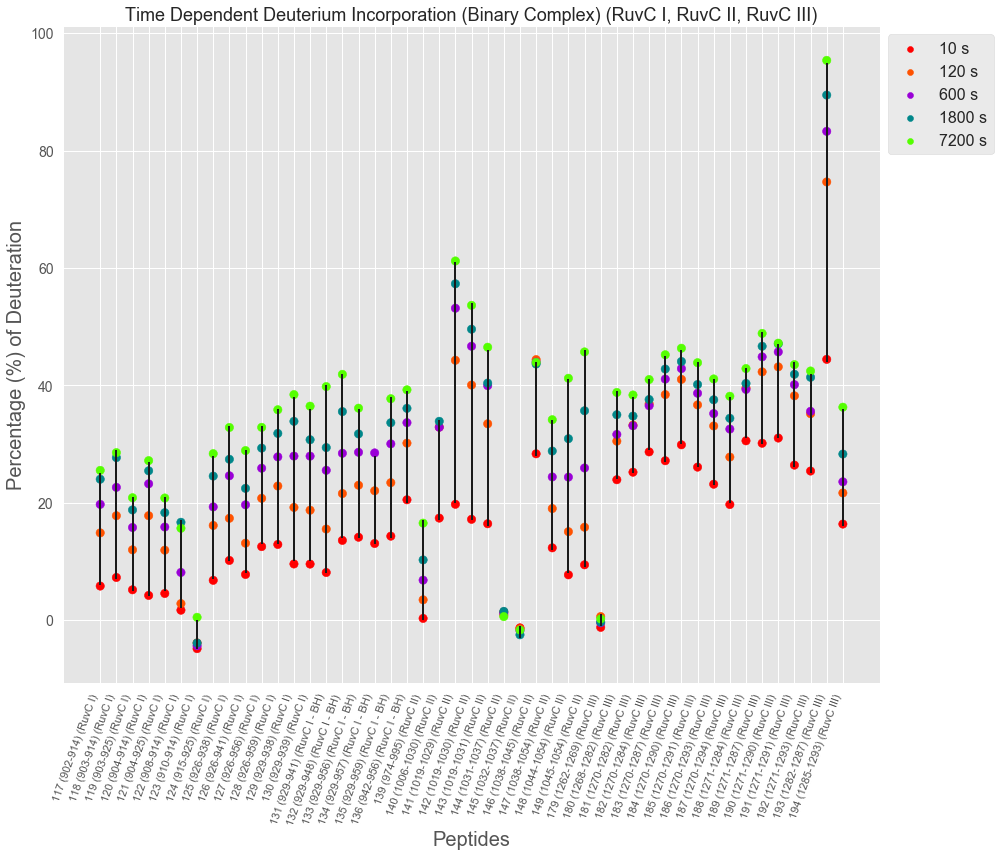

In [14]:
pl.bubble_plot(domains =["RuvC I", "RuvC II", "RuvC III"], state ="Binary",
                figsize =(14,12), plot_style = 'ggplot', pdf= False, tiff= True)

((<Figure size 1800x1800 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1a1e88d710>]),)

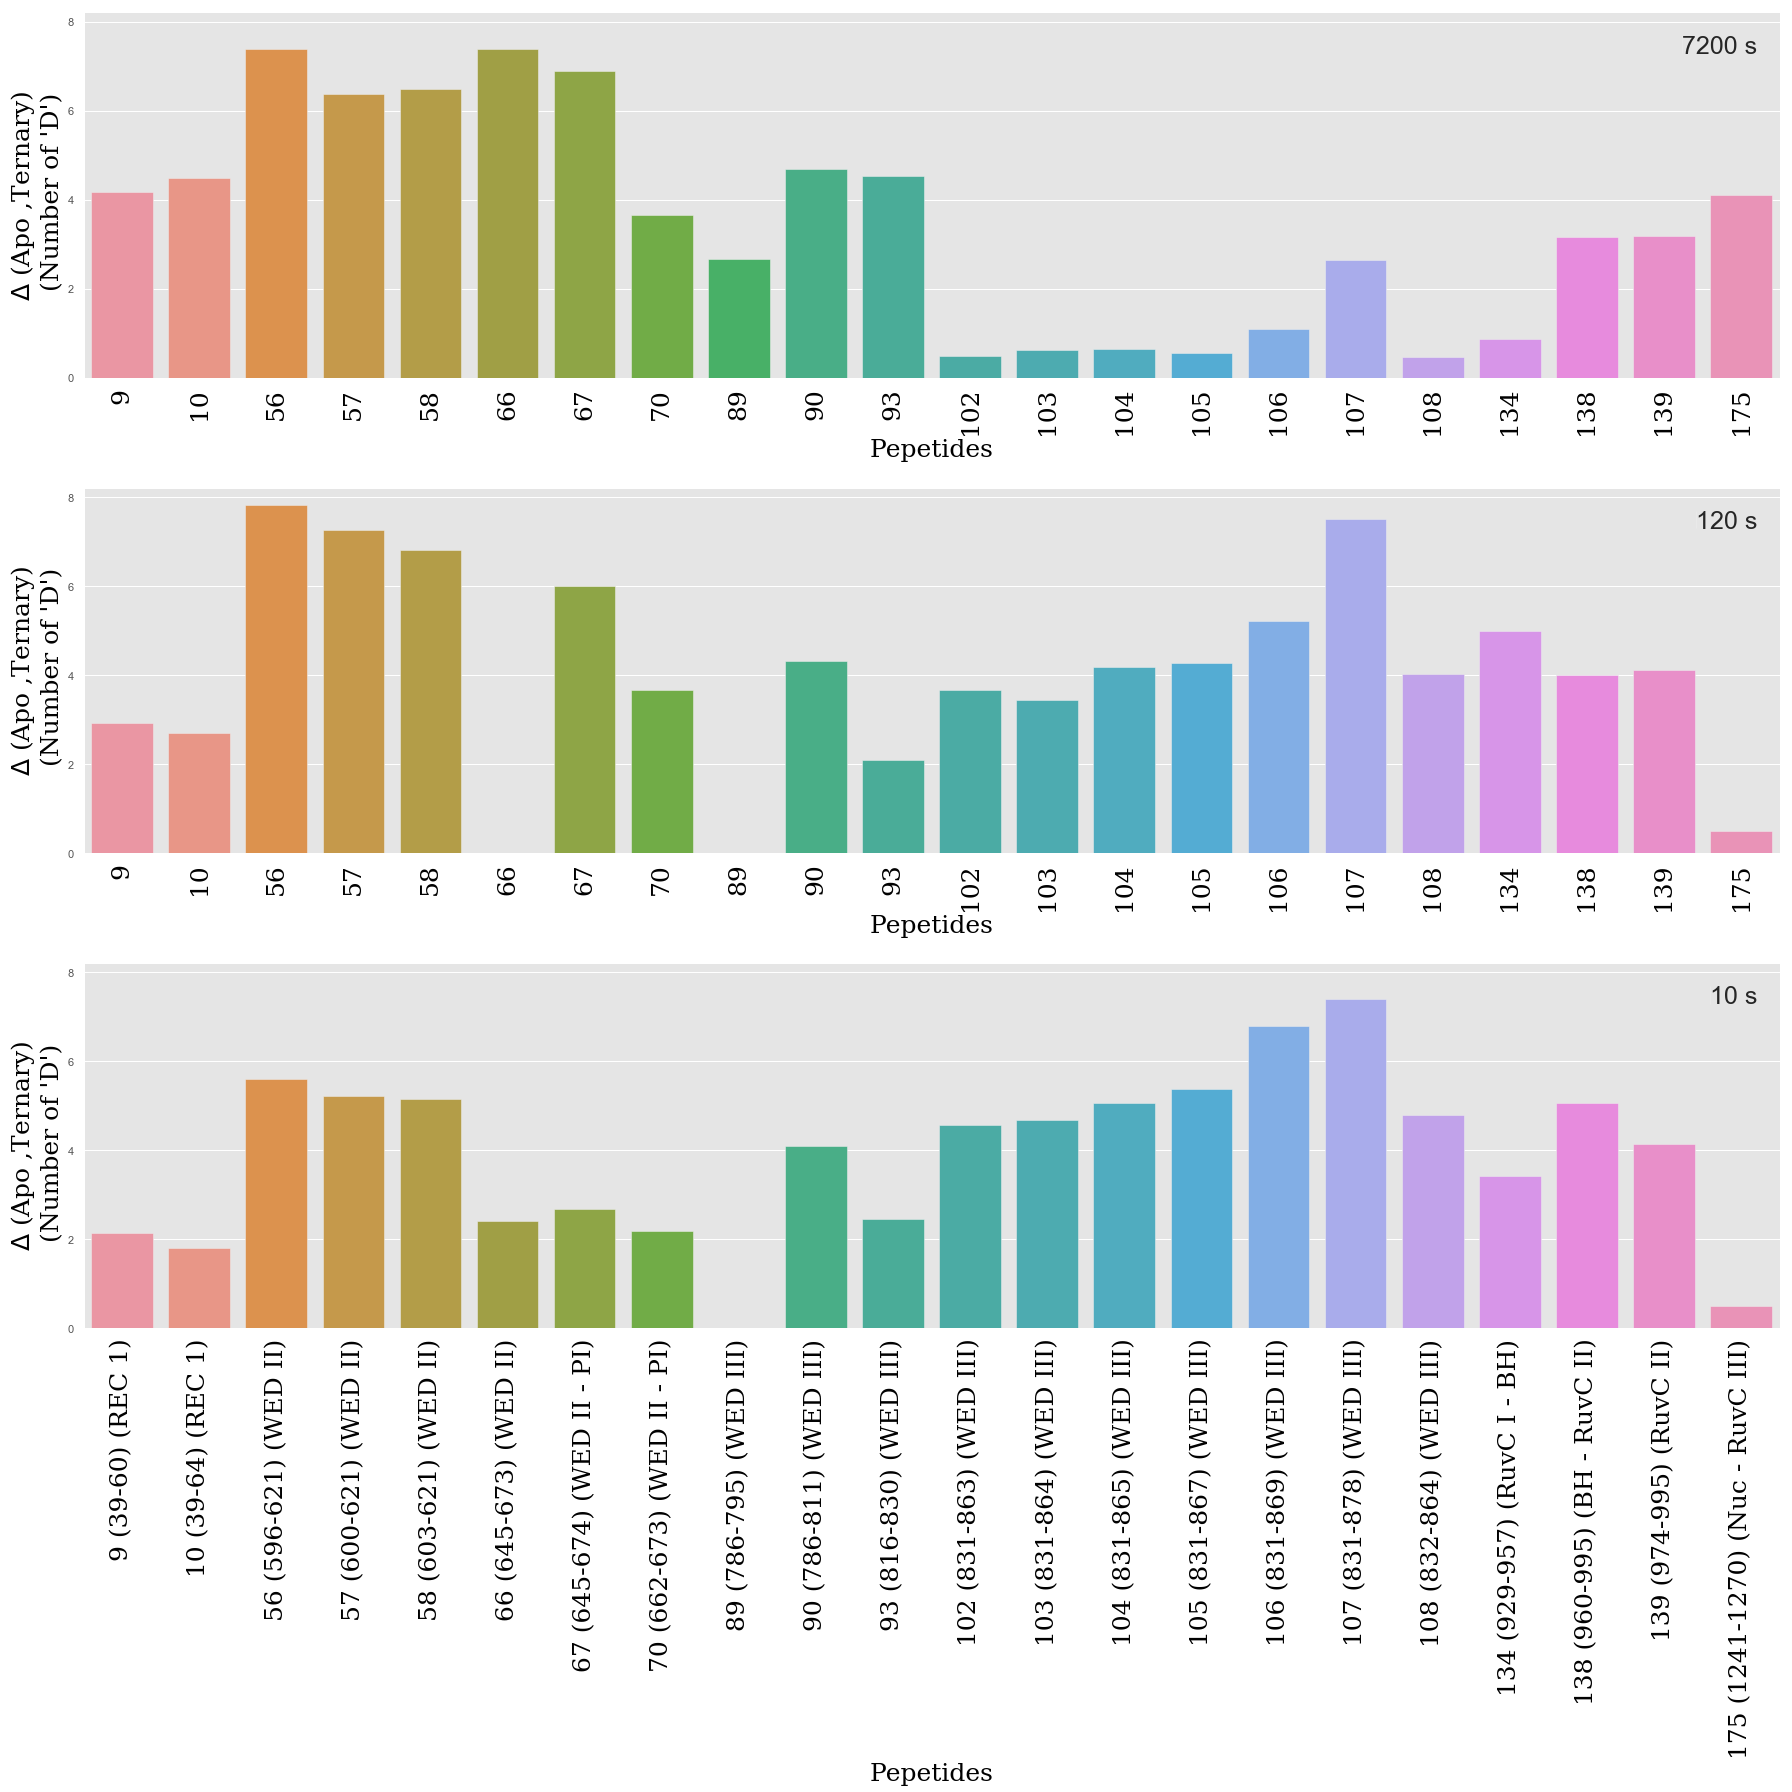

In [15]:
pep, idx = pl.pep_diff_sig_class(dstate=("Apo", "Ternary"), st1_st2=True, er_da=4)
len(idx)
pl.barplots(time_points=[7200, 120, 10], pep_class=idx, dstate=("Apo", "Ternary"),figsize = (25,25),
            domains=None),

(<Figure size 1800x1800 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a20bbae48>])

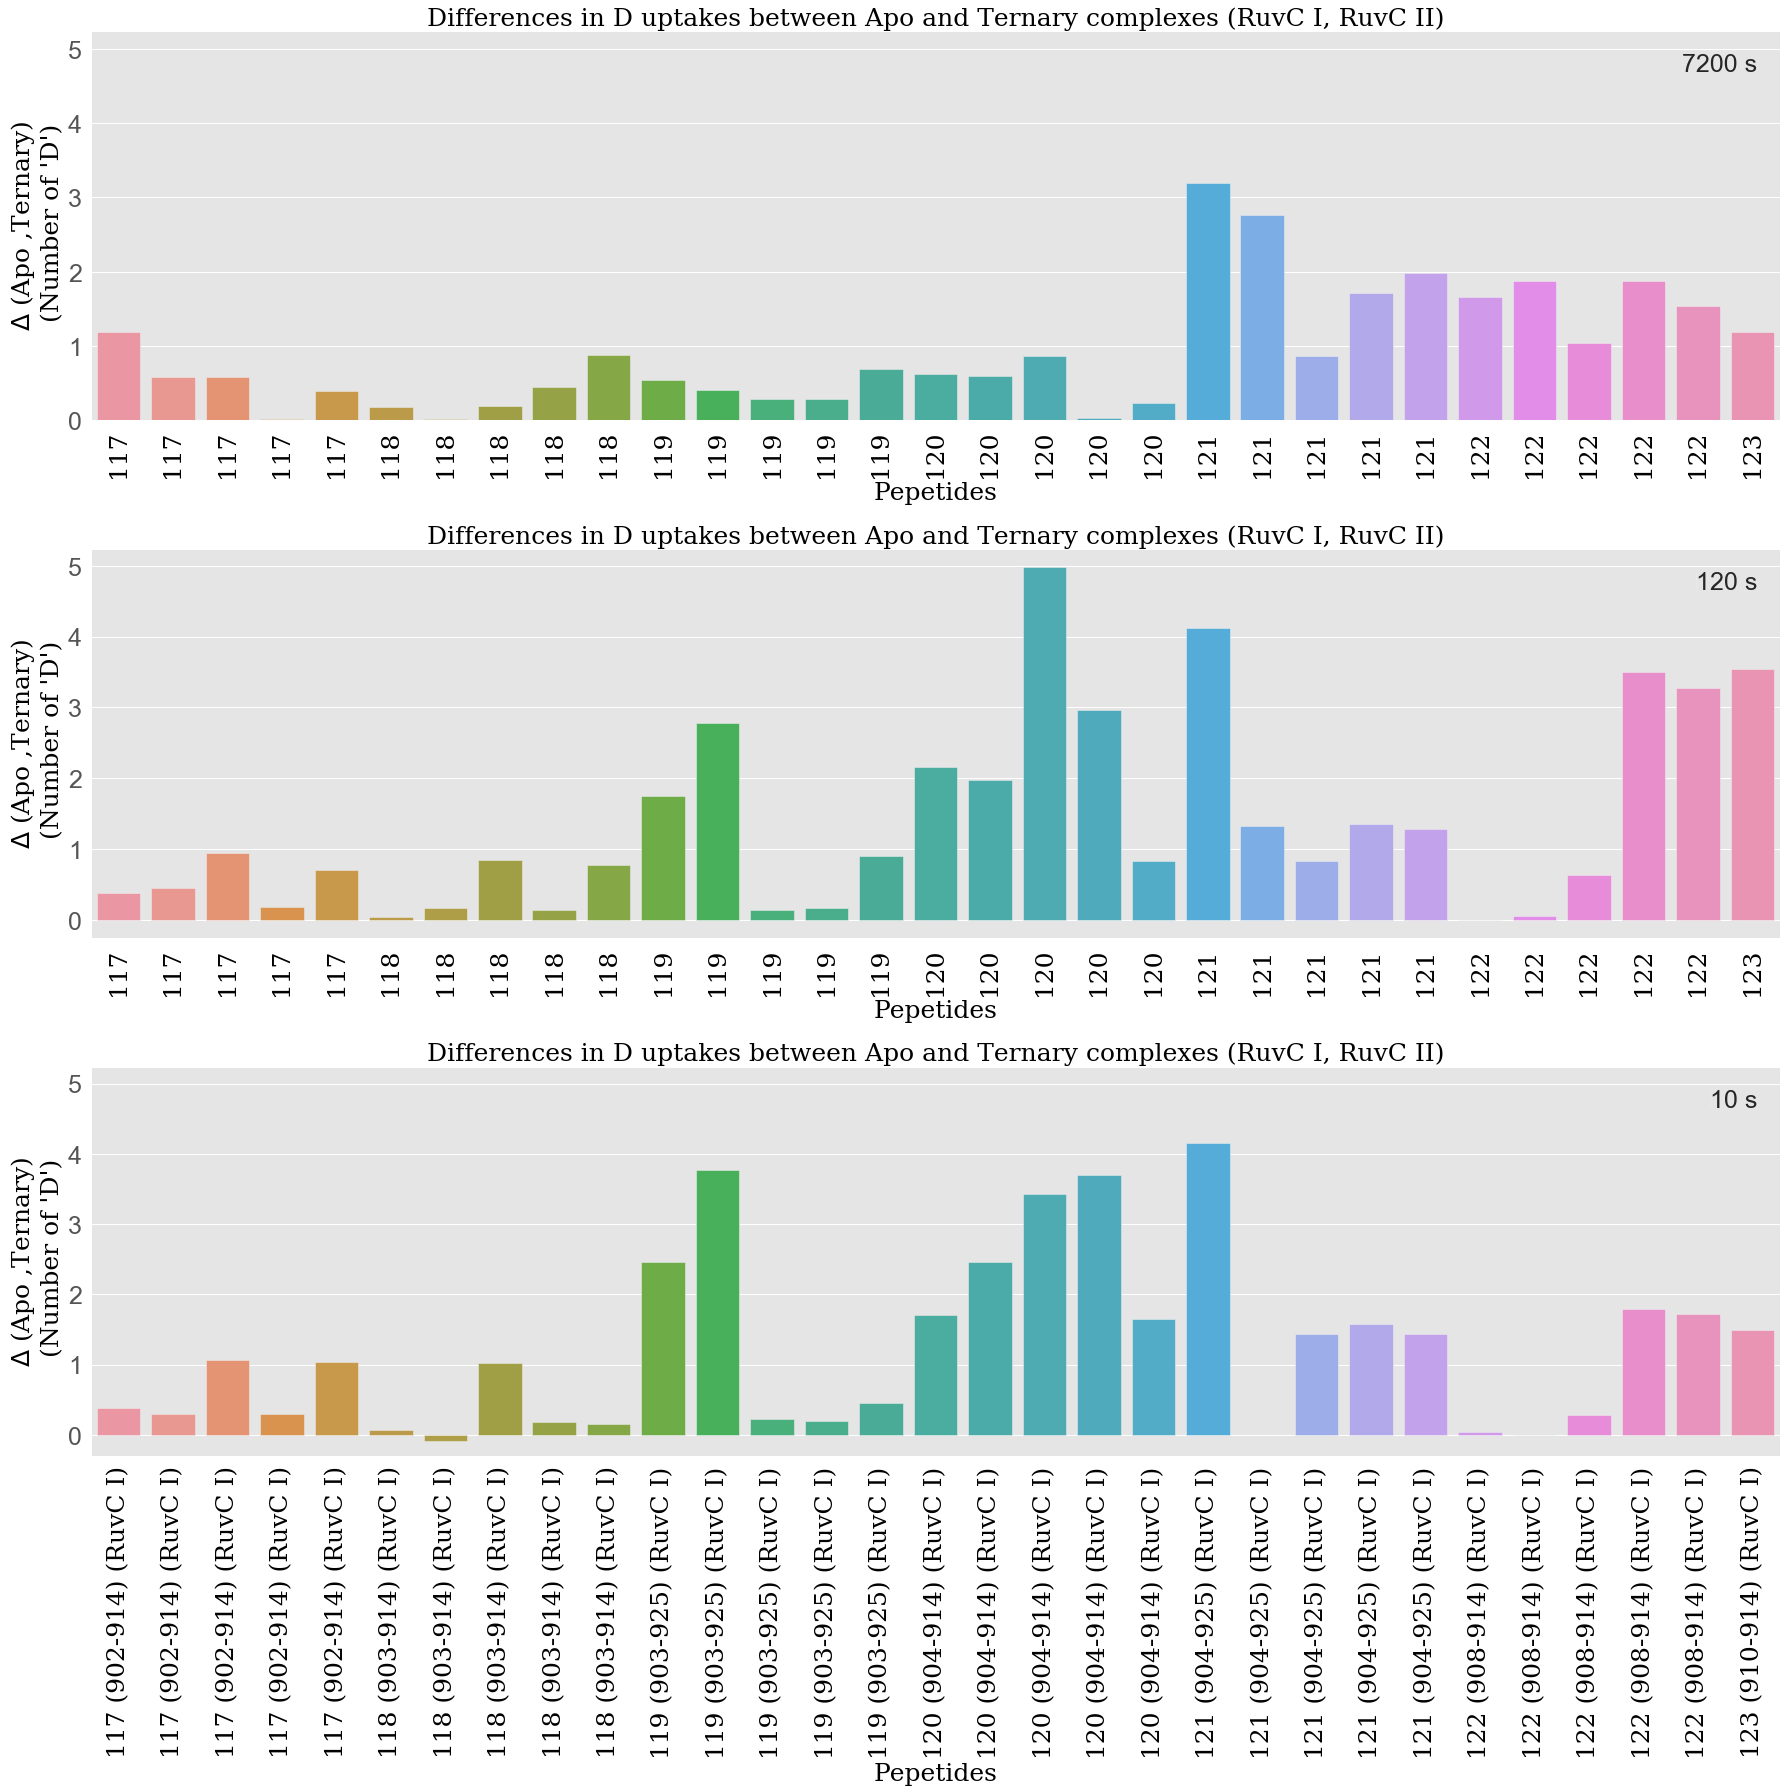

In [16]:
pl.barplots(time_points=[7200, 120, 10], pep_class=None, dstate=("Apo", "Ternary"),figsize = (25,25),
            domains=["RuvC I", "RuvC II"])

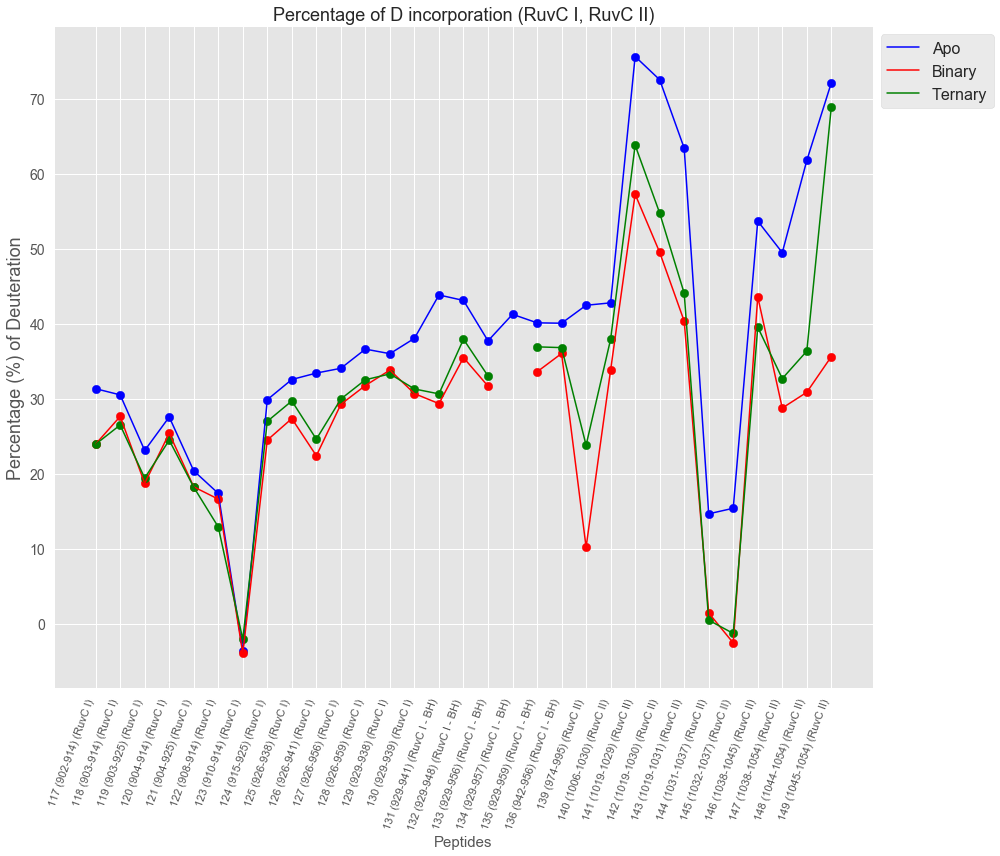

In [17]:
pl.scatter_plot(domains =["RuvC I", "RuvC II"], states =["Apo", "Binary", "Ternary"], timepoint = "t4",
                    figsize =(14,12))

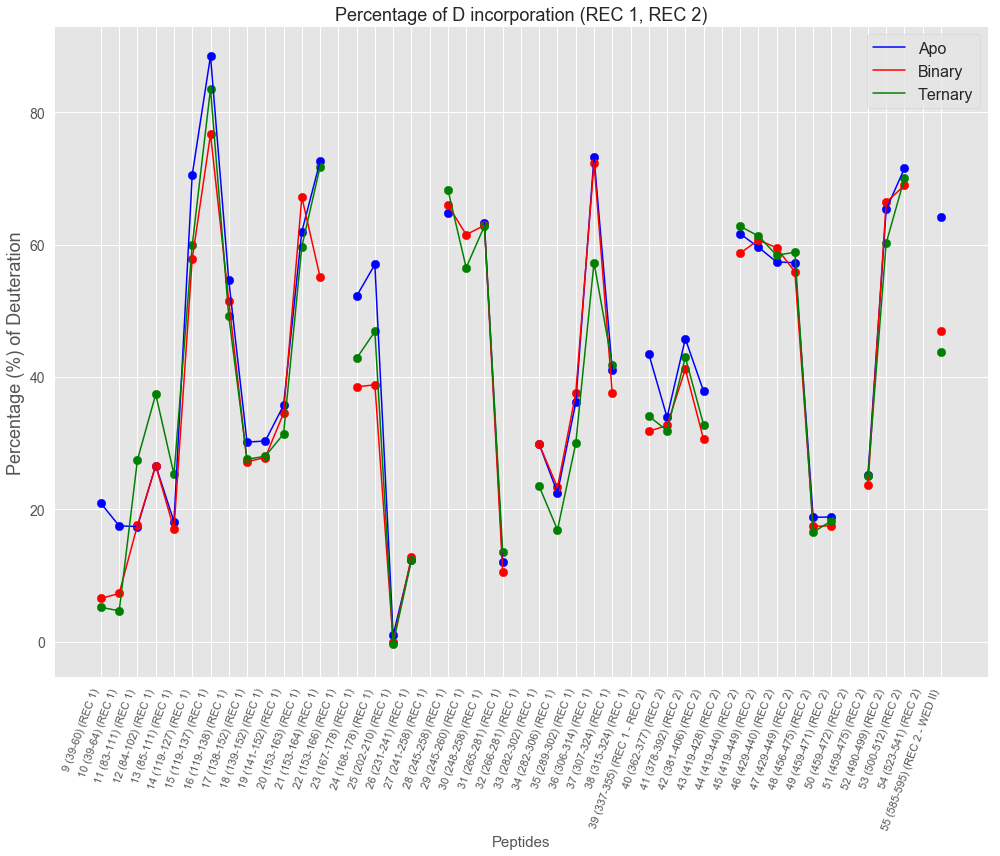

In [18]:
pl.scatter_plot(domains =["REC 1", "REC 2"], states =["Apo", "Binary", "Ternary"], timepoint = "t3",
                    figsize =(14,12))

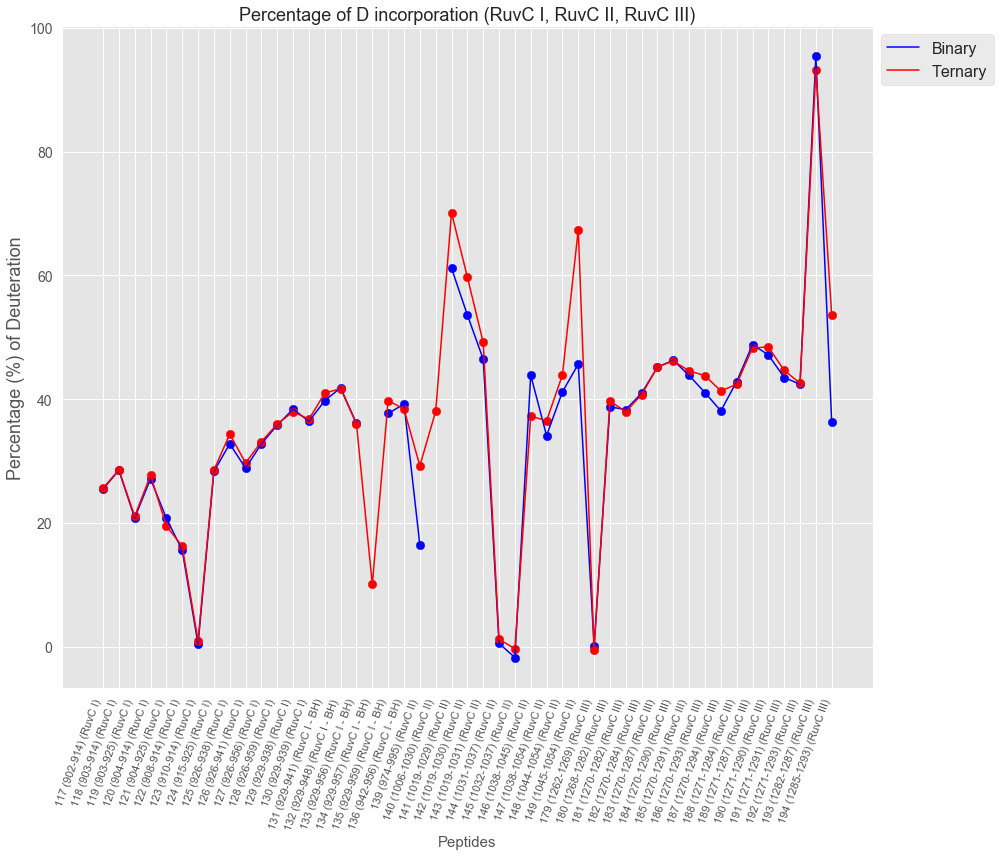

In [19]:
pl.scatter_plot(domains =["RuvC I", "RuvC II", "RuvC III"], states =["Binary", "Ternary"], timepoint = "t5",
                    figsize =(14,12))

#### Here I plotted only the selected peptides. 

#### Here I plotted only the peptides from the domains "RuvC I" and "RuvC II". If I don't specify, it will plot all 194 peptides. 

#### Note, the above function is to fish out peptides which has differences in D uptakes by 1 dalton between the "Apo" and "Binary" states (specified by er_da =1). This peptides can be selectively ploted using the plot function.

#### Here I first fished out the peptides of 5 da differences, then plotted them. 

In [20]:
peptides, indexes =pl.pep_diff_sig_class(dstate=('Apo', 'Binary'), st1_st2=True, er_da=1)
peptides[:10]

array(['1. FVNKYSL (7-13) (WED I)', '2. FVNKYSLSK (7-15) (WED I)',
       '3. FVNKYSLSKTLRF (7-19) (WED I)',
       '4. TLRFELIPQGKTLENIKAR (16-34) (WED I - REC 1)',
       '5. TLRFELIPQGKTLENIKARGLIL (16-38) (WED I - REC 1)',
       '6. ELIPQGKTLENIKAR (20-34) (WED I - REC 1)',
       '7. ELIPQGKTLENIKARGLIL (20-38) (WED I - REC 1)',
       '8. IPQGKTLENIKAR (22-34) (WED I - REC 1)',
       '9. DDEKRAKDYKKAKQIIDKYHQF (39-60) (REC 1)',
       '10. DDEKRAKDYKKAKQIIDKYHQFFIEE (39-64) (REC 1)'], dtype=object)

In [21]:
peptides, indexes =pl.pep_diff_sig_class(dstate=('Binary', 'Ternary'), st1_st2=True, er_da=5)
peptides, indexes

(array(['56. FKLNFENSTLANGWDKNKEPDNTAIL (596-621) (WED II)',
        '57. FENSTLANGWDKNKEPDNTAIL (600-621) (WED II)',
        '58. STLANGWDKNKEPDNTAIL (603-621) (WED II)',
        '66. AIKENKGEGYKKIVYKLLPGANKMLPKVF (645-673) (WED II)',
        '67. AIKENKGEGYKKIVYKLLPGANKMLPKVFF (645-674) (WED II - PI)'],
       dtype=object), [56, 57, 58, 66, 67])

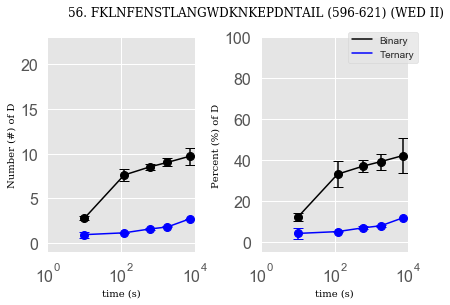

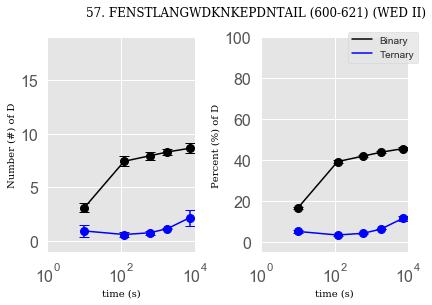

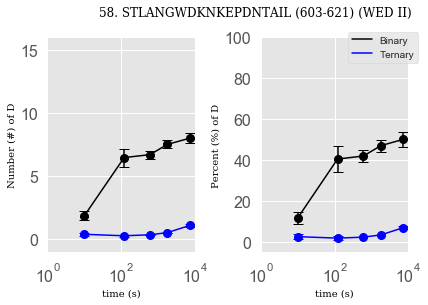

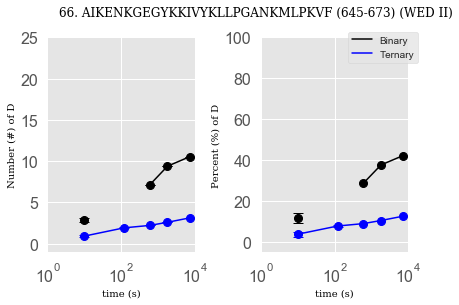

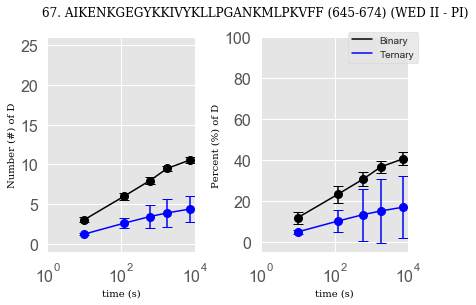

In [55]:
pl.uptake_plots(plot_states=['Binary', "Ternary"], pep_class = indexes )


#### The difference plots are the uptake plots as well as plots for the difference between states.

#### Here I plotted barplots for selected peptides.

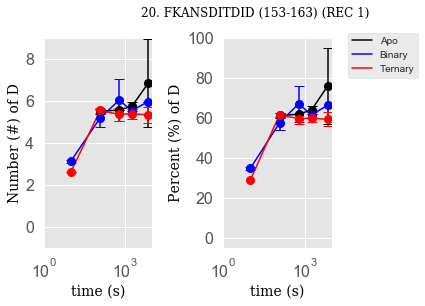

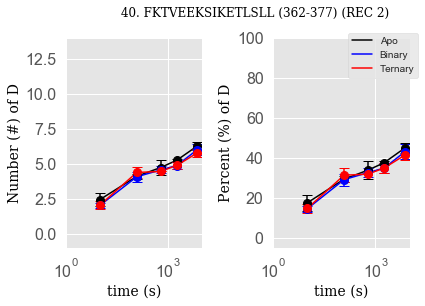

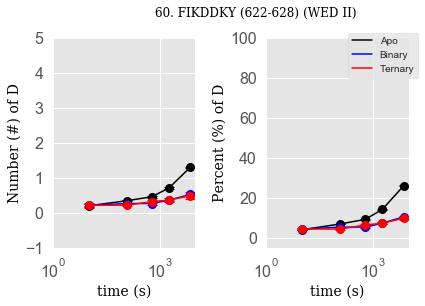

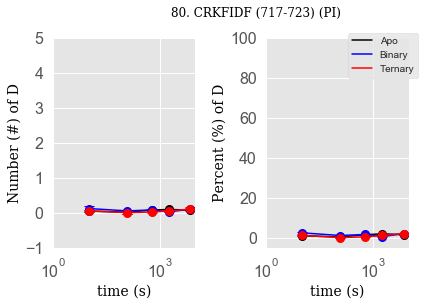

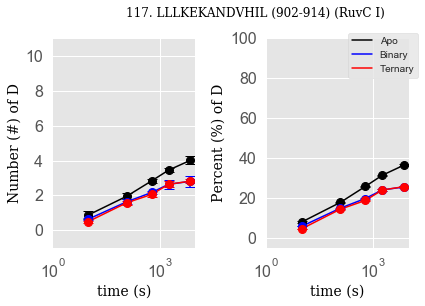

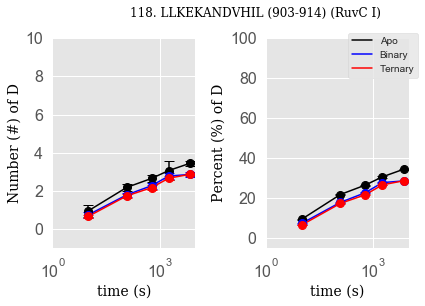

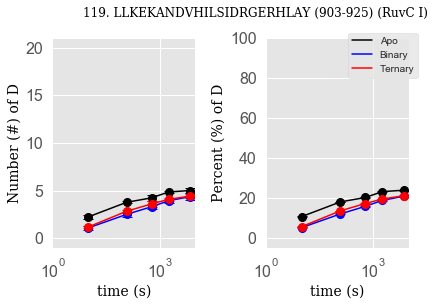

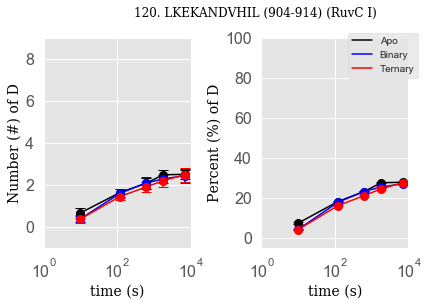

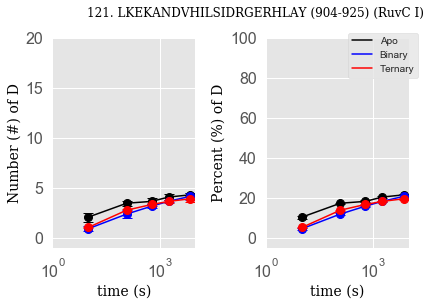

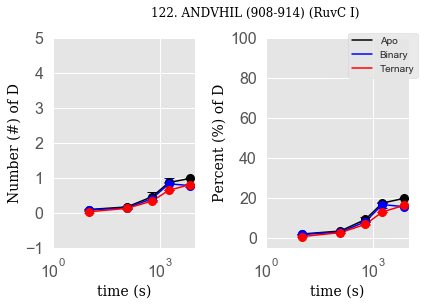

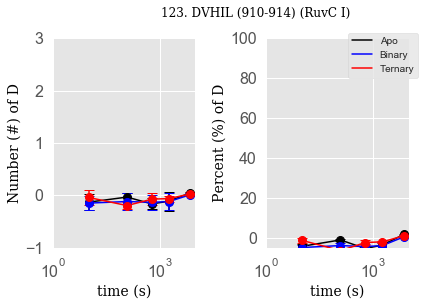

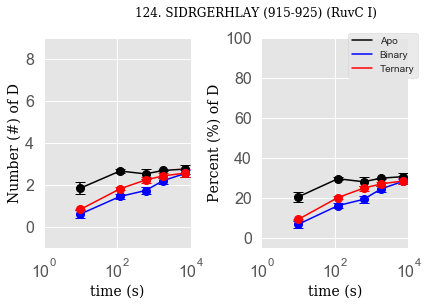

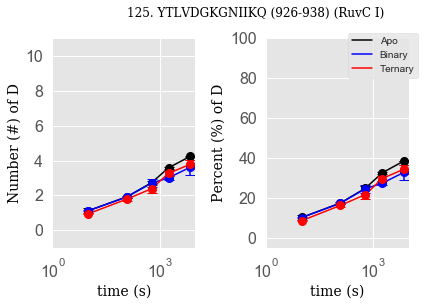

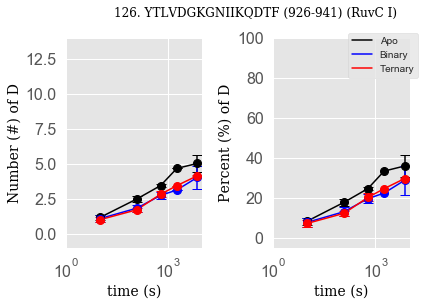

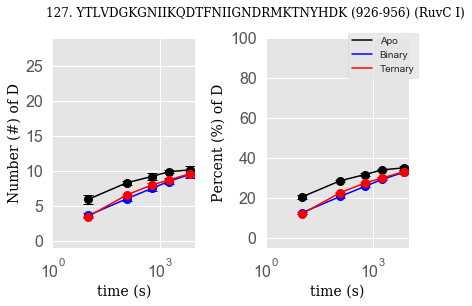

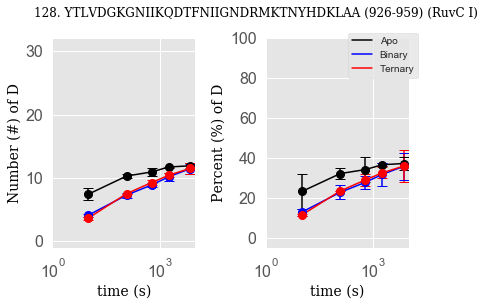

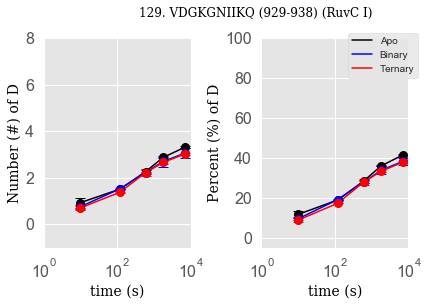

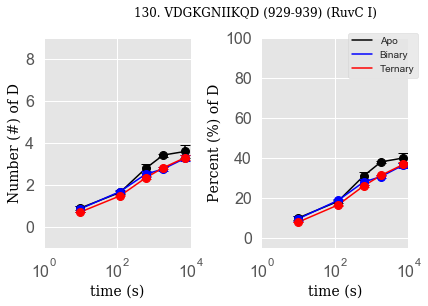

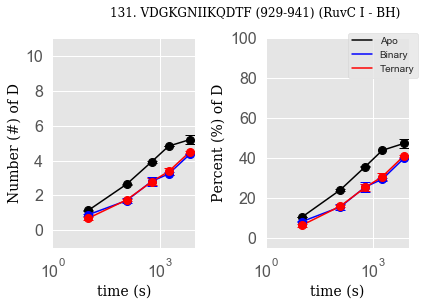

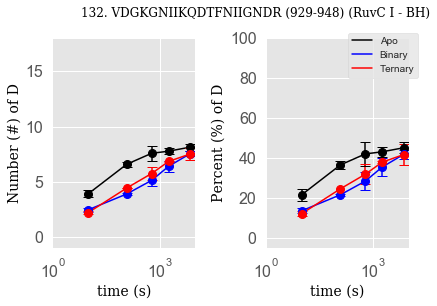

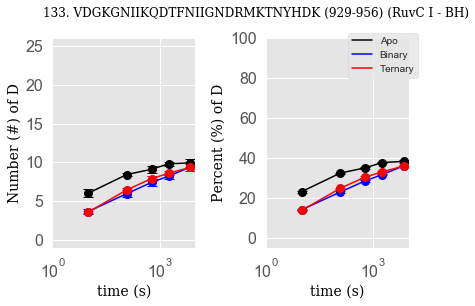

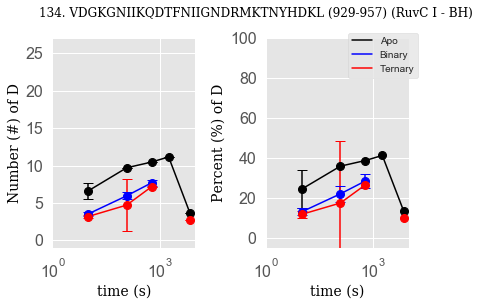

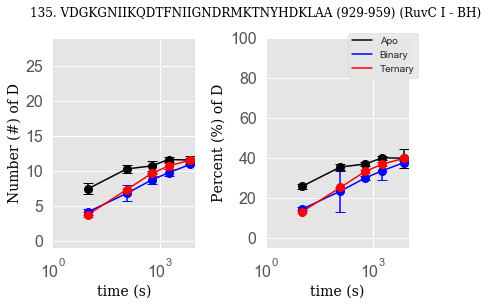

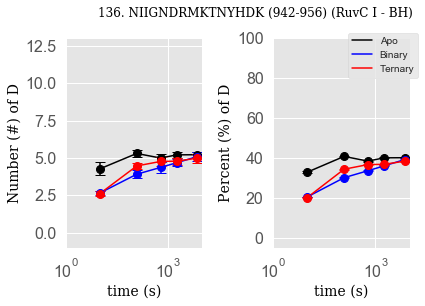

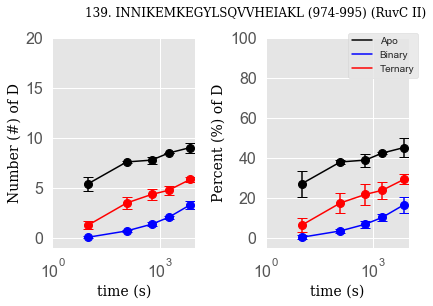

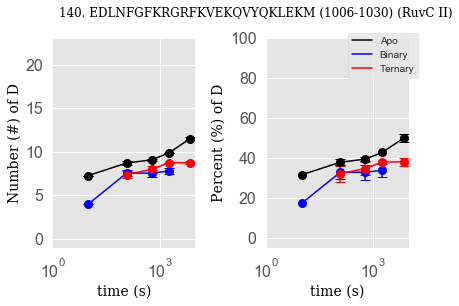

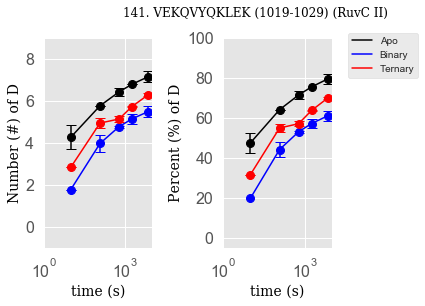

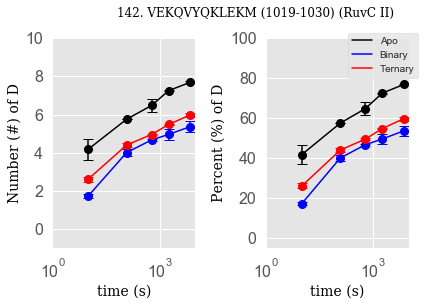

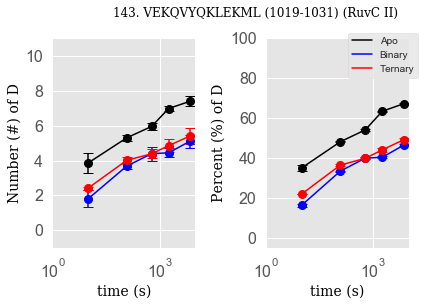

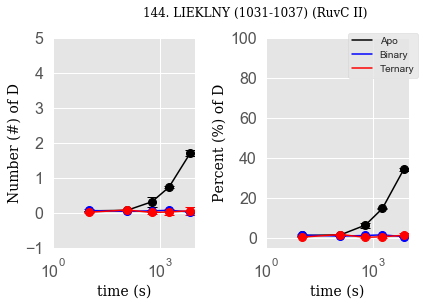

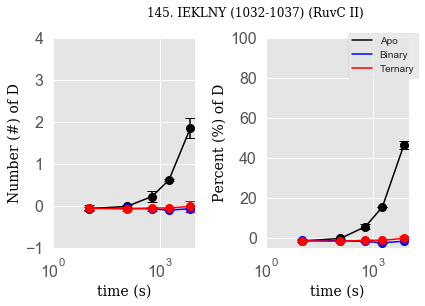

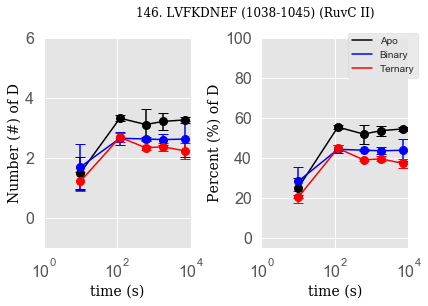

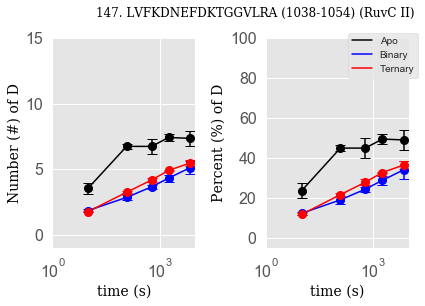

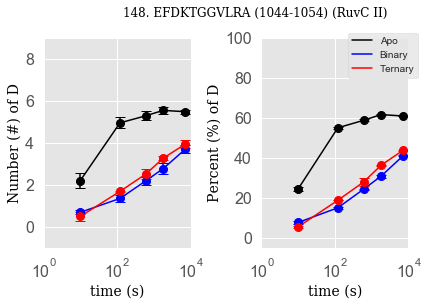

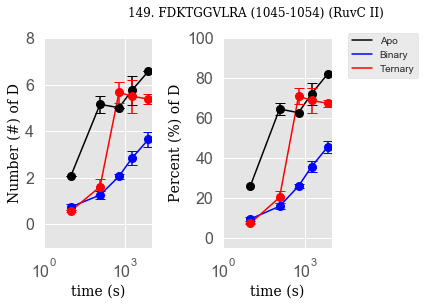

In [58]:


pl.uptake_plots(plot_states=['Apo', 'Binary', "Ternary"], domains =["RuvC I", "RuvC II"])

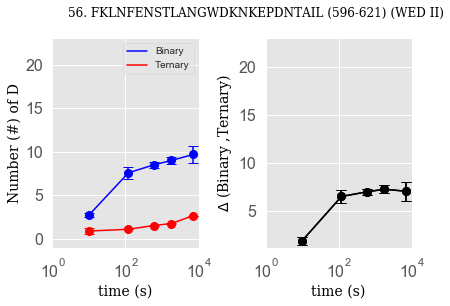

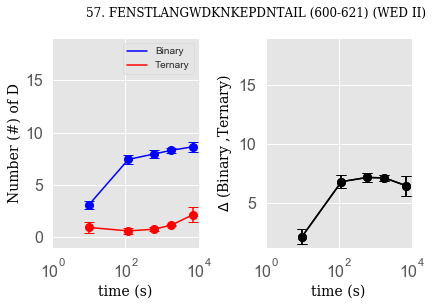

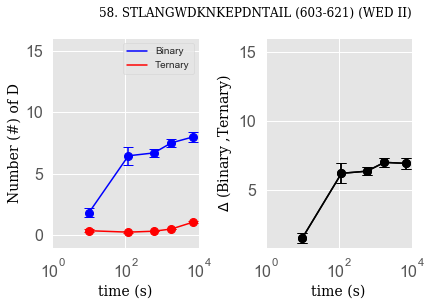

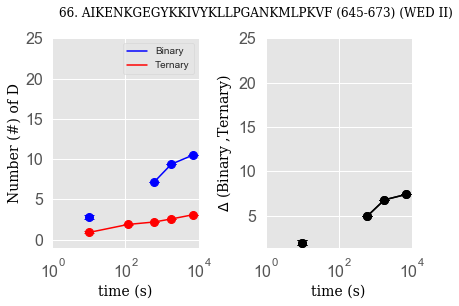

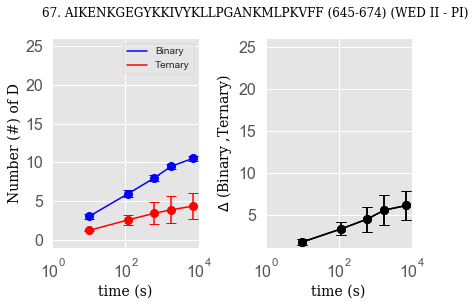

In [59]:
pl.difference_plots(diff_states = ("Binary", "Ternary"), pep_class = indexes, pdf = True)

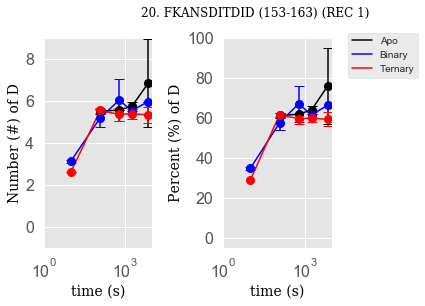

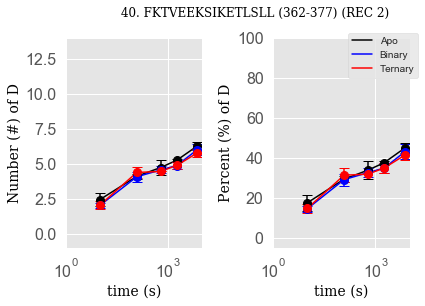

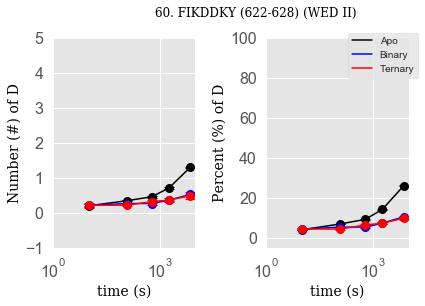

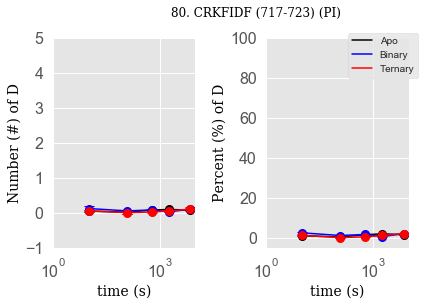

In [60]:
pl.uptake_plots(plot_states=["Apo",'Binary', "Ternary"], pep_no  =[20,40, 60,80])

In [ ]:
pep, idx = pl.pep_diff_sig_class(dstate=("Apo", "Binary"), st1_st2=True, er_da=1)
data = fd.loc[idx1]
#data = data.loc[data['Deut Time (sec)'] == 120]
len(data)
plt.figure(figsize =(8,10))
br = sns.barplot(y="Apo_Binary", x ="idx_pep", data =data.loc[data['Deut Time (sec)'] == 120], label = "tm", color="r", dodge =False)
br.legend(loc= "upper right", frameon=False,fontsize=15)
br.set(xlim=(0, 10),ylabel="Pepetides", xlabel = "Number of D")

#br.set_xlabel("Number of D",fontsize=15)
#locs, labels = plt.xticks()


plt.xticks(ticks, axis_label, rotation=90, fontsize=15)
axis_label=data.peps.tolist()
ticks = len(data.pepsdmn) 
br.set_yticklabels(axis_label, rotation=90)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


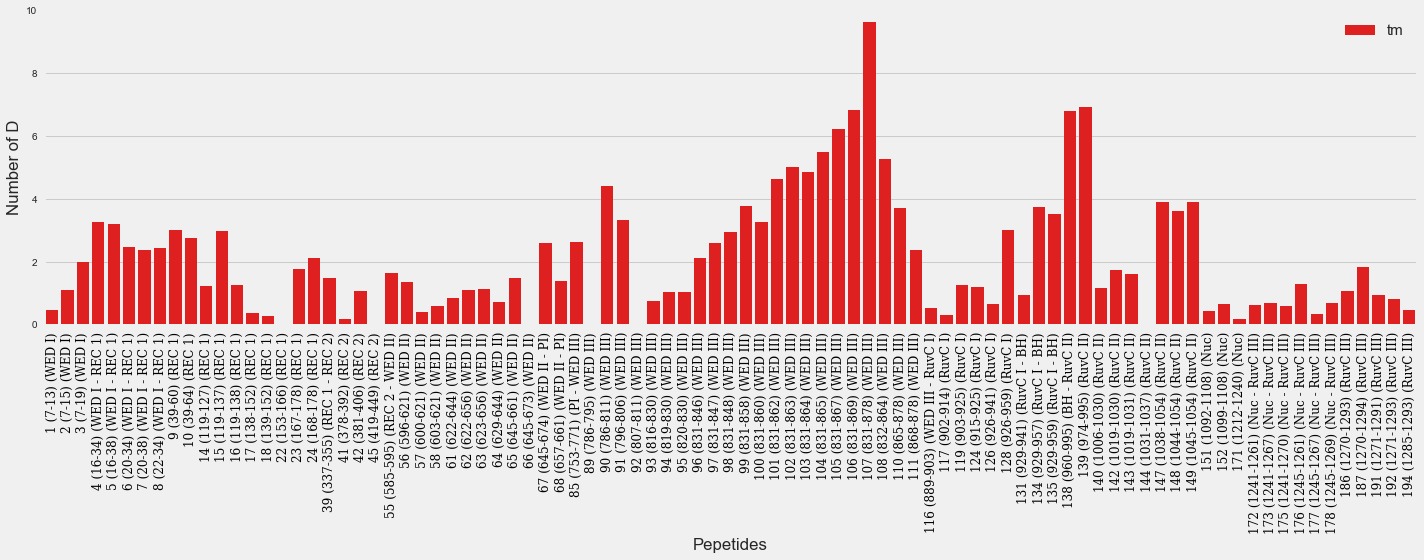

In [142]:
plot_style = 'fivethirtyeight'
data = fd.loc[idx]

data = data.loc[data['Deut Time (sec)'] == 120]
plt.figure(figsize =(20,8))
br = sns.barplot(x ="idx_pep", y="Apo_Binary", data=data, label = "tm", color="r", dodge =False)
br.legend(loc= "upper right", frameon=False,fontsize=15)
br.set(ylim=(0, 10), xlabel="Pepetides", ylabel = "Number of D")

axis_label=data.idxdmn.tolist()
ticks = len(data.idxpep) 
font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 12}
br.set_xticklabels(axis_label,rotation=90, fontdict = font, ha ="center")
plt.tight_layout()


In [242]:
def barplots( fd, pep_idx, time_points = None, dstate=("Apo", "Binary"), plot_style = 'fivethirtyeight' ):
    """
    This function will plot D uptake for a set of peptides over time.

    """
    data = fd.loc[pep_idx]
    
    st1, st2 = dstate
    y = st1 + "_" + st2
    ystd = st1 + "_" + st2 +"_"+ "std"
    
    plt.style.use(plot_style)
    plt.figure(figsize =(18,14))

    for idx, tm in enumerate(time_points):
        fig = plt.subplot(len(time_points),1, idx+1)
        
        br = sns.barplot(x ="idxdmn", y=y, data =data[data['Deut Time (sec)'] == tm], label = tm)
        br.legend(loc= "upper right", frameon=False,fontsize=15)
        br.set(ylim=(0, 10), xlabel="Pepetides", ylabel = "Number of D")
        tick_labels=data[data['Deut Time (sec)'] == tm].idxdmn.tolist()
        nticks = range(len(data[data['Deut Time (sec)'] == tm].idxdmn)) 
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 12}
        br.set_xticks(nticks)
        br.set_xticklabels(tick_labels,rotation=90, fontdict = font, ha ="center")
        
    axes = np.array(fig.axes)
        
    plt.tight_layout()
    
    return plt.gcf(), axes





In [114]:
fd[fd.domains == "WED I"]

,Protein State_Apo,Start,End,Sequence,Deut Time (sec),maxD,#D_Apo,%D_Apo,Conf Interval (#D)_Apo,#Pts_Apo,...,Binary_Apo,Binary_Ternary,Ternary_Apo,Ternary_Binary,Apo_Binary_std,Apo_Ternary_std,Binary_Apo_std,Binary_Ternary_std,Ternary_Apo_std,Ternary_Binary_std
idx,,,,,,,,,,,,,,,,,,,,,
1,Apo,7,13,FVNKYSL,10,5,0.658,13.157,0.229,2.0,...,-0.357,0.130,-0.487,-0.130,0.028231,0.050249,0.028231,0.044385,0.050249,0.044385
1,Apo,7,13,FVNKYSL,120,5,1.433,28.651,0.106,2.0,...,-0.453,0.186,-0.639,-0.186,0.016279,0.050448,0.016279,0.050220,0.050448,0.050220
1,Apo,7,13,FVNKYSL,600,5,2.425,48.508,3.174,2.0,...,-1.473,0.127,-1.600,-0.127,0.366085,0.353204,0.366085,0.097739,0.353204,0.097739
1,Apo,7,13,FVNKYSL,1800,5,2.880,57.594,NaN,1.0,...,-1.830,0.048,-1.878,-0.048,0.105000,0.090000,0.105000,0.138293,0.090000,0.138293
1,Apo,7,13,FVNKYSL,7200,5,3.084,61.682,3.650,2.0,...,-1.798,0.269,-2.067,-0.269,0.406100,0.411491,0.406100,0.067602,0.411491,0.067602
2,Apo,7,15,FVNKYSLSK,10,7,1.273,18.192,0.234,4.0,...,-0.436,0.252,-0.688,-0.252,0.150233,0.166883,0.150233,0.084865,0.166883,0.084865
2,Apo,7,15,FVNKYSLSK,120,7,2.714,38.773,0.445,4.0,...,-1.116,-0.013,-1.103,0.013,0.281996,0.281313,0.281996,0.054562,0.281313,0.054562
2,Apo,7,15,FVNKYSLSK,600,7,4.460,63.720,0.222,4.0,...,-2.866,-0.050,-2.816,0.050,0.142415,0.175414,0.142415,0.111400,0.175414,0.111400
2,Apo,7,15,FVNKYSLSK,1800,7,4.839,69.133,0.190,4.0,...,-3.260,-0.162,-3.098,0.162,0.174040,0.262520,0.174040,0.266242,0.262520,0.266242


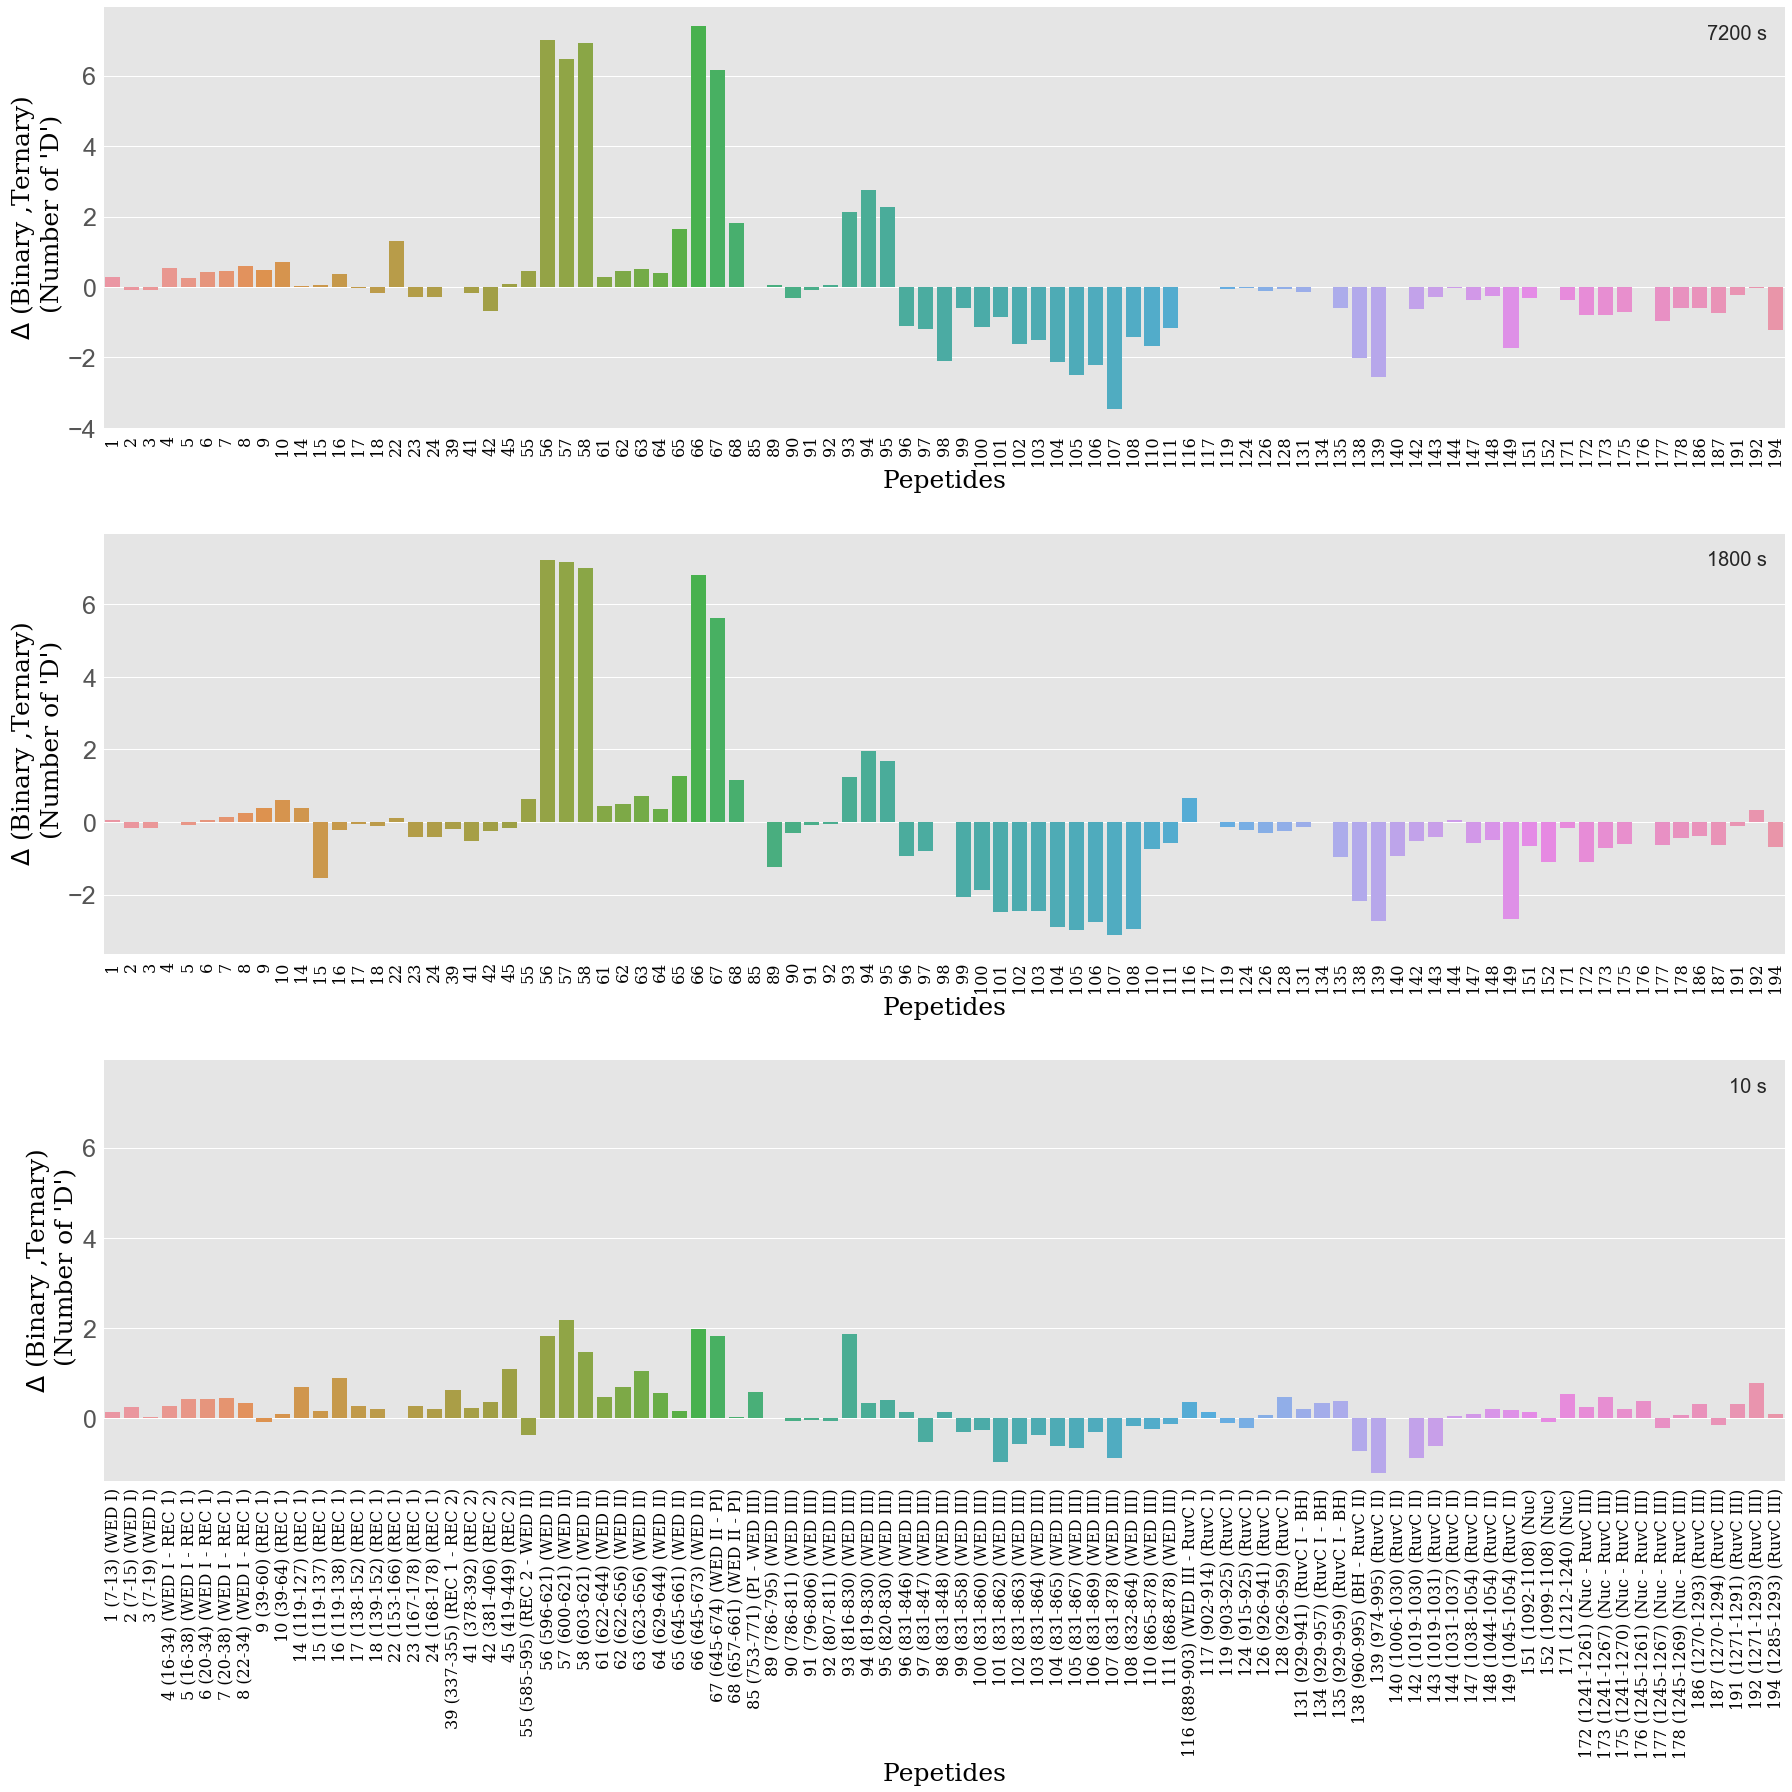

In [84]:
fig, axes, ylim = barplots(fd, idx, time_points =[7200,1800,10],
                           dstate=("Binary", "Ternary"), plot_style = 'ggplot' )

In [85]:
time_points =[120,1800]
range(len(time_points))[-1]

1

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


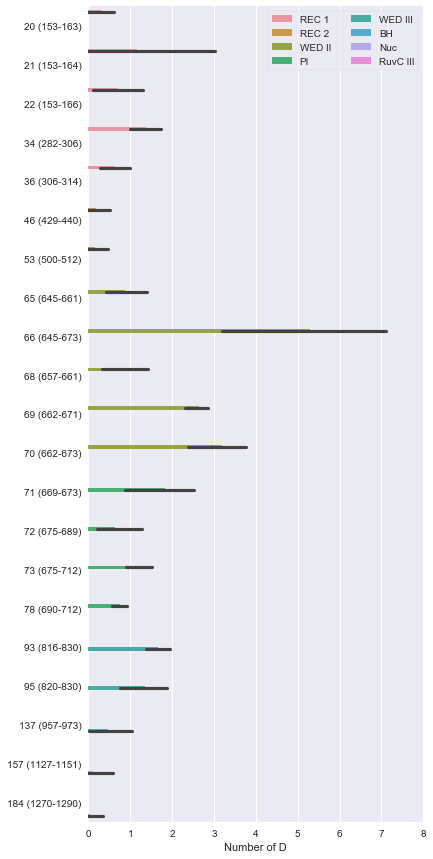

In [17]:
f, ax = plt.subplots(figsize=(6, 15))

ax = sns.barplot(
y = "idx1", x = "Binary_Ternary", hue = 'domains_start',
data =data)

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 8), ylabel="",
       xlabel="Number of D")
sns.despine(left=True, bottom=True)

In [ ]:
            #locs, labels = plt.xticks()


            #plt.xticks(ticks, axis_label, rotation=90, fontsize=15)
        #axis_label=data.pepsdmn.unique.tolist()
        #ticks = len(data.pepsdmn.unique())  

        for i, ax in enumerate(axss):

            ax.legend(loc= "upper right", frameon=False,fontsize=15)
            ax.set(ylim=(0, 10), xlabel="")
            ax.set_ylabel("Number of D",fontsize=15)

        #locs, labels = plt.xticks()

        plt.xticks(ticks, axis_label, rotation=90, ha="right" fontsize=15)
            #plt.xls(axis_label, rotation=90, ha="right", fontsize=15)

            #sns.despine(left=True, bottom=True)

            #plt.tight_layout()
            #plt.savefig("barplot1.pdf", dpi=500, bbox_extra_artists=(ax1,ax2,ax3), bbox_inches='tight')



In [8]:
pl = plots()
data = pl.cal_diff()
pep, sig = pl.pep_diff_sig_class(dstate=('Binary', "Ternary"), st1_st2=True, er_da=0.5)
data = data.loc[sig]
#data = data.loc[data["Deut Time (sec)"] ==120]
data = data[["Deut Time (sec)","idx1","Binary_Ternary", 'domains',
       'domains_start', 'pepsdmn']]

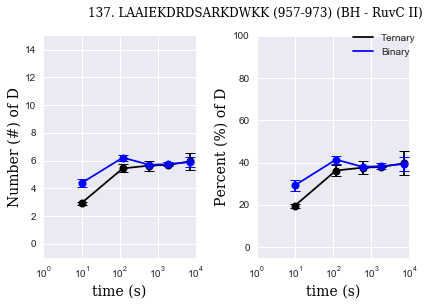

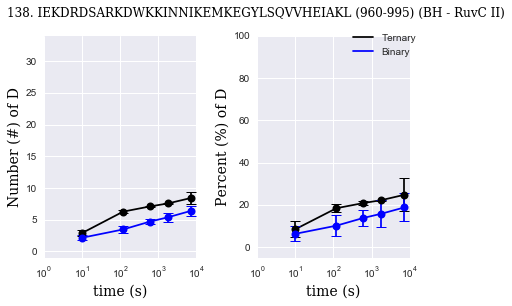

In [11]:
pl = plots()
pl.uptake_plots(plot_states = ["Ternary","Binary"],
                pep_class = None,  domains = ["BH"],
                pep_no = None,tiff = True, pdf = False)

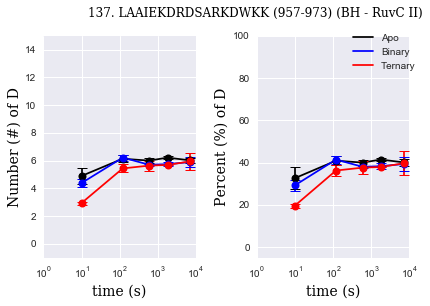

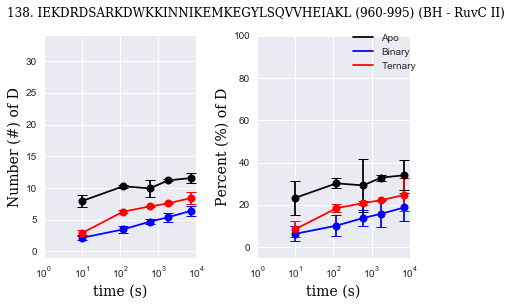

In [12]:
pl.uptake_plots(plot_states = ["Apo","Binary", "Ternary"],
                domains = ["BH"], pep_no = None,
                tiff = False, pdf = False)

In [13]:
pl.pep_map

{'BH': range(954, 972),
 'Nuc': range(1079, 1255),
 'PI': range(663, 763),
 'REC 1': range(25, 340),
 'REC 2': range(340, 592),
 'RuvC I': range(893, 954),
 'RuvC II': range(972, 1079),
 'RuvC III': range(1255, 1301),
 'WED I': range(1, 25),
 'WED II': range(592, 663),
 'WED III': range(763, 893)}

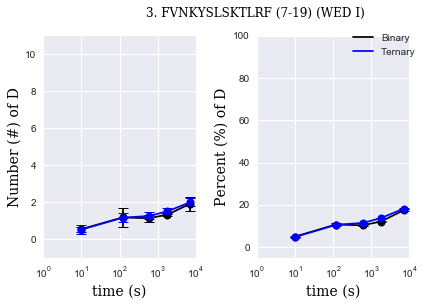

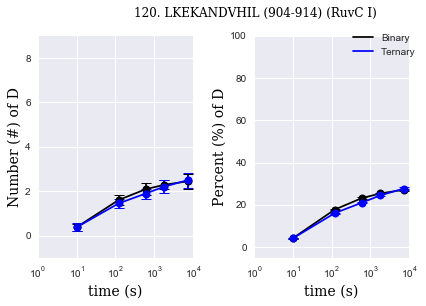

In [14]:
pl.uptake_plots(plot_states = ["Binary", "Ternary"],
                domains = None, pep_no = [3,120],
                tiff = False, pdf = False)

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


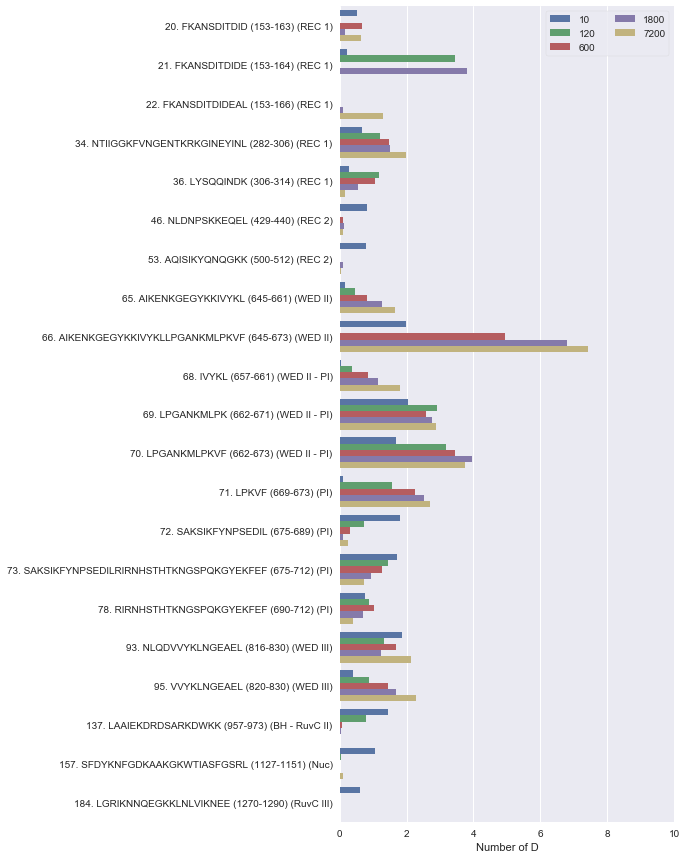

In [10]:

f, ax = plt.subplots(figsize=(6, 15))

ax = sns.barplot(y = "pepsdmn",x = "Binary_Ternary", hue='Deut Time (sec)',  data =data,)

#ax2 = sns.barplot(
#x = "peps", y = "Binary_Ternary", hue = 'domains',
#data =data.loc[data['Deut Time (sec)']==1800], ax = ax2)

#ax3 = sns.barplot(
#x = "peps", y = "Binary_Ternary", hue = 'domains',
#data =data.loc[data['Deut Time (sec)']==7200], ax = ax3)
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 10),ylabel="",
xlabel="Number of D",label = 'biger')
sns.despine(left=True, bottom=True)


#data = data.loc[data['Deut Time (sec)']==120]
